# Solutions of exercises for Chapter 6

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as ts
from statsmodels.multivariate.manova import MANOVA
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

import cvxopt
from cvxopt.solvers import qp
from cvxopt import matrix


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.width=None

sns.set(style="darkgrid")
register_matplotlib_converters()
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 18

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

cvxopt.solvers.options['show_progress'] = False

### Exercise 1

Using the historical log returns of the following tickers: CME, GS, ICE, LM, MS, for the year 2014 (in file investment_data.csv), estimate their means $\mu$ and
covariance matrix $\Sigma$; let $R$ be the median of the $\mu$s.

1. Test if the returns series are random via the autocorrelation function.
2. Solve Markowitz’s minimum variance objective to construct a portfolio with the above stocks, that has expected return at least $R$. The weights $\omega_i$ should sum to 1. Assume short selling is possible
3. Generate a random value uniformly in the interval $[0.956\mu_i, 1.056\mu_i]$, for each stock$i$. Resolve Markowitz’s objective with these mean returns  instead of $\mu_i$ as in (1). Compare the results in (1) and (2)
4. Repeat three more times and average the five portfolios found in (1), (2) and (3).Compare this portfolio with the one found in (1)
5. Repeat (1), (2) and (3) under no short selling and compare the results obtained with short selling
6. Use the LASSO method to construct the portfolio and compare it with the result in (5)

#### Data Preparation and Exploration

In [203]:
pd.read_csv('../datasets/investment_data.csv').head()

,date,CME,GS,ICE,LM,MS
0,2014-01-02,-0.006393,-0.002089,-0.001424,-0.009475,-0.010579
1,2014-01-03,0.015780,0.007098,0.005683,0.011772,0.015350
2,2014-01-06,-0.010152,0.006825,0.002564,-0.001838,0.003485
3,2014-01-07,-0.007426,-0.006040,0.005988,0.013246,-0.003168
4,2014-01-08,-0.009814,0.000841,-0.003562,-0.007743,0.001268


In [204]:
#Just parse the data and rename for consistency
eq_returns = pd.read_csv('../datasets/investment_data.csv',parse_dates=True,index_col='date')
eq_returns.index.name='Date'

In [205]:
eq_returns.info()
eq_returns.describe()
#Data looks OK

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2014-01-02 to 2014-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CME     251 non-null    float64
 1   GS      251 non-null    float64
 2   ICE     251 non-null    float64
 3   LM      251 non-null    float64
 4   MS      251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


,CME,GS,ICE,LM,MS
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.000724,0.000447,-0.000005,0.000894,0.000912
std,0.011687,0.010914,0.013375,0.015189,0.013648
min,-0.043570,-0.029194,-0.048805,-0.061703,-0.035402
25%,-0.005385,-0.005517,-0.007783,-0.007405,-0.007229
50%,0.001130,0.001113,-0.000148,0.001021,0.001027
75%,0.006718,0.007515,0.008343,0.010405,0.009851
max,0.032369,0.034944,0.036351,0.042038,0.042820


#### Part 1

In [344]:
mu = eq_returns.mean(axis=0)
sigma = eq_returns.cov()
sigma.index.name='Covariance Matrix'
R = mu.quantile(q = 0.5).round(4)
pd.DataFrame({'mu':mu})
sigma
print(f'median return R: {R}')

,mu
CME,0.000724
GS,0.000447
ICE,-0.000005
LM,0.000894
MS,0.000912


,CME,GS,ICE,LM,MS
Covariance Matrix,,,,,
CME,0.000137,0.000073,0.000099,0.000096,0.000090
GS,0.000073,0.000119,0.000072,0.000104,0.000119
ICE,0.000099,0.000072,0.000179,0.000093,0.000072
LM,0.000096,0.000104,0.000093,0.000231,0.000129
MS,0.000090,0.000119,0.000072,0.000129,0.000186


median return R: 0.0007


We write a function to test the acf (20 lags) and see if it is significant (at the 95%) then apply it to each instrument.
The data looks indeed like random walks.

In [207]:
def test_for_random(series):
    (acf,alpha) = ts.acf(series,nlags=20,alpha=0.05)
    return pd.Series({'IsRandom': not np.array([acf < alpha[:,0], acf > alpha[:,1]]).any()})
eq_returns.stack().groupby(level=1).apply(test_for_random)

CME  IsRandom    True
GS   IsRandom    True
ICE  IsRandom    True
LM   IsRandom    True
MS   IsRandom    True
dtype: bool

#### Part 2

We are going to leverage the excellent CVSOPT package for this exercise specifically the qp solver. See user guide [here](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)


In [302]:
n = mu.shape[0]
n_eq = 1
n_iq = 1
P = matrix(np.asmatrix(sigma))
# Our formulation only minimizes risk so q is 0
q = matrix(np.zeros((n,1)))

#Equality Constraint sum of weights needs to be 1
A = matrix(1.0,(n_eq,n))
b = matrix(1.0,(n_eq,1))

#Inequality Constraint. Min return needs to be at least R. Inequalities are expressed as upper bounds so need to be flipped for lower bounds.
G = -matrix(0.0,(n_iq,n))
h = -matrix(0.0,(n_iq,1))

G[0,:] = -np.asmatrix(mu)
h[0,:] = -R                    

res = qp(P,q,G,h,A,b)

In [303]:
w = np.array(res['x'])
print(f'Weights:\n{np.round(w[:,0],2)}')
print(f'Expected Return: {mu.dot(w).round(5)[0]}')
print(f'Sum of W: {w.sum()}')

Weights:
[ 0.51  0.37 -0.06  0.09  0.1 ]
Expected Return: 0.0007
Sum of W: 1.0


Optimization puts most weight to CME and GS and smaller weights on LM and MS. It shorts IC which had negative return but only a little since return was almost 0
We confirm that Expected return is R and weights sum to 1. 

#### Part 3

In [298]:
new_mu = np.random.uniform(0.95*mu,1.05*mu)
print(f'random returns: {new_mu.round(5)}')

random returns: [ 0.00076  0.00044 -0.       0.00092  0.00087]


In [237]:
#We'll need it for other parts of the exercise so let's create a function to run the optimization. 
#We add suport for no short selling constraints

def run_markowits(mu,sigma,min_return,short_restricted=False):
    n = mu.shape[0]
    n_eq = 1
    
    n_iq = n+1 if short_restricted else 1
    
    P = matrix(np.asmatrix(sigma))
    # Our formulation only minimizes risk so q is 0
    q = matrix(np.zeros((n,1)))

    #Equality Constraint sum of weights needs to be 1
    A = matrix(1.0,(n_eq,n))
    b = matrix(1.0,(n_eq,1))

    #Inequality Constraint. Min return needs to be at least R. Inequalities are expressed as upper bounds so need to be flipped for lower bounds.
    G = -matrix(0.0,(n_iq,n))
    h = -matrix(0.0,(n_iq,1))

    G[0,:] = -np.asmatrix(mu)
    h[0,:] = -min_return        
    
    if short_restricted:
        #If shorts not allowed we add additional n constraints that each weight is > 0. The bottom part of the G matrix is diagonal -1
        G[1:n+1,:] = -np.diag(np.ones(n))
    
    
    res = qp(P,q,G,h,A,b)
    
    w = np.array(res['x'])
    ret = mu.T.dot(w)[0]
    vol = np.sqrt(w.T.dot(sigma.dot(w))[0][0])
    return (w,ret,vol)
                

In [329]:
w,ret,vol = run_markowits(new_mu,sigma,R)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')



Weights:[ 0.52  0.39 -0.06  0.09  0.06],ret: 0.0007, vol:0.0103


The weights for this slightly modified set of expected return resulted in meaningfully different weights highlighting a known deficiency of Markowits mean-variance approach: Extreme sensitivity to expected returns estimates which are notoriously very noisy.

#### Part 4

In [330]:
additional_mus = np.array([np.random.uniform(0.95*mu,1.05*mu) for i in range(3)])
all_mus = np.vstack((mu.values, new_mu,additional_mus))

mus_mean = all_mus.mean(axis=0)
print(f'Average mus: {mus_mean.round(5)}')

Average mus: [ 0.00072  0.00044 -0.       0.00089  0.00089]


In [331]:
w,ret,vol = run_markowits(mus_mean,sigma,R)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[ 0.52  0.37 -0.07  0.09  0.09],ret: 0.0007, vol:0.0103


As we average multiple random $\mu$s we see that the weigths tend to align with the original optimization

#### Part 5

Let's see the effect of a short sell restriction

In [332]:
#Regular mu
w,ret,vol = run_markowits(mu,sigma,R,short_restricted=True)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[0.48 0.26 0.   0.1  0.17],ret: 0.0007, vol:0.0104


In [333]:
#New mu
w,ret,vol = run_markowits(new_mu,sigma,R,short_restricted=True)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[0.49 0.28 0.   0.1  0.13],ret: 0.0007, vol:0.0103


In [334]:
w,ret,vol = run_markowits(mus_mean,sigma,R,short_restricted=True)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[0.48 0.24 0.   0.1  0.17],ret: 0.0007, vol:0.0104


In the case of long only allocation the weights are quite extreme putting almost 50% of the portfolio in CME. This results in reducing significantly the effects of diversification.

#### Part 6

We'll solve the LASSO problem still using QP. The LASSO add a non linear penalty to the objective that penalizes for the L1 norm (sum of absolute weights) with a penaly hyperparameter $\rho$. 

A common approach to add this penalty is to split the weigths $w$ in positive weights $w^{+}$ and negative weights $W^{-}$. The total weights are then: $w = w^{+} - w^{-}$ and the pe penalty term now just becomes: $\rho w^{+} + w^{-}$. To keep things working we'll also need to ensure that both $w^{+}$ and $w^{-}$ must be positive so we add that additional inequality constraint.

To ensure all is working we'll add a very small amount of penalty $\rho$ and we should retrieve a similar set of weights of the original problem.

In [407]:
rho = 10e-9

n = mu.shape[0]
n_eq = 1
n_iq = 2*n +1
P = matrix(0.0,(2*n,2*n))
P[0:n,0:n] = np.asmatrix(sigma)
P[0:n,n:2*n] = -np.asmatrix(sigma)
P[n:2*n,0:n] = -np.asmatrix(sigma)
P[n:2*n,n:2*n] = np.asmatrix(sigma)

# Our formulation only minimizes risk so q is 0
q = matrix(rho,(2*n,1))

#Equality Constraint sum of weights needs to be 1
A = matrix(0.0,(n_eq,2*n))
A[0,0:n] = np.ones(n)
A[0,n:2*n]= -np.ones(n)

b = matrix(1.0,(n_eq,1))

#Inequality Constraint. Min return needs to be at least R. Inequalities are expressed as upper bounds so need to be flipped for lower bounds.
G = -matrix(0.0,(n_iq,2*n))

G[1:,:] = -np.diag(np.ones(2*n))
h = matrix(0.0,(n_iq,1))

G[0,0:n] = -np.asmatrix(mu)
G[0,n:2*n] = np.asmatrix(mu)
h[0,:] = -R                    

res = qp(P,q,G,h,A,b)

In [408]:
w = np.array(res['x']).reshape(2,n)
print(f'W+:{np.round(w[0],2)}\nW-:{np.round(w[1],2)}')
w_total = w[0]-w[1]
print(f'W:{np.round(w_total,2)}')

print(f'Expected Return: {mu.dot(w_total).round(5)}')
print(f'Sum of W: {w_total.sum().round(1)}')

W+:[0.8  0.74 0.52 0.5  0.51]
W-:[0.29 0.37 0.58 0.41 0.42]
W:[ 0.51  0.37 -0.06  0.09  0.1 ]
Expected Return: 0.0007
Sum of W: 1.0


As we can see the weights are the same  as the original problem. Let's try with a  more binding $\rho$

In [409]:
rho = 10e-4
q = matrix(rho,(2*n,1))
res = qp(P,q,G,h,A,b)

In [410]:
w = np.array(res['x']).reshape(2,n)
print(f'W+:{np.round(w[0],2)}\nW-:{np.round(w[1],2)}')
w_total = w[0]-w[1]
print(f'W:{np.round(w_total,2)}')

print(f'Expected Return: {mu.dot(w_total).round(5)}')
print(f'Sum of W: {w_total.sum()}')

W+:[0.48 0.26 0.   0.1  0.17]
W-:[0. 0. 0. 0. 0.]
W:[0.48 0.26 0.   0.1  0.17]
Expected Return: 0.0007
Sum of W: 1.0


After trying a few values for $\rho$  we find that for values > 10e-5 the weights are actually similar to the weigth calculated in part 5. 

### Exercise 2

Suppose that it is impractical to construct an efficient portfolio using all assets. One alternative is to find a portfolio, made up of a given set of $n$ stocks, that tracks the efficient portfolio closely in the sense of minimizing the variance of the difference in returns.

Specifically, suppose that the efficient portfolio has (random) rate of return $r_{M}$. Suppose that there are $N$ assets with (random) rates of return $r_{1},r_{2},…,r_{n}$. We wish to find the portfolio whose rate of return is $r = \alpha_{1}r_{1} + \alpha_{2}r_{2} + ...+ \alpha_{n}r_{n} (  with \sum_{i=1}^{n} \alpha_{i} = 1)$ by minimizing $Var(r-r_{M})$.

1. Find a set of equations for the $\alpha_{i}$s.
2. Another approach is to minimize the variance of the tracking error subject to achieving a given mean return. Find the equation for the $\alpha_{i}$s that are tracking efficient.
3. Instead of minimizing $Var(r-r_{M})$, obtain the $\alpha_{i}$s that result from minimizing mean squares of the difference of $(r-r_{M})$. Note the mean squares is the sum of variance and bias squared.

#### Part 1

Let's define $\alpha$ as the vector of weigths, and $\eta = Cov(r_{i},r_{M})$

$$Var(r-r_{M}) = \mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}}) - (r_{M} - \mathbb{E}{r_{M}}))^{2}}$$
$$=\mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}}))^{2}} - 2 \mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}})(r_{M} - \mathbb{E}{r_{M}})} + \mathbb{E}{(r_{M} - \mathbb{E}{r_{M}})^{2}}$$
$$=\alpha^{T}\Sigma\alpha - 2\alpha^{T}\eta + Var(r_{M})$$

We want to minimize $Var(r-r_{M})$ subject to $\sum_{j=1}^{n}\alpha_{j}=1$

We build the Lagrangian function:
$$L(\alpha,\lambda) = \alpha^{T}\Sigma\alpha - 2\alpha^{T}\eta + Var(r_{M})-2\lambda(\alpha^{T}e -1)$$

con $e = (1,...,1)^{T}$
We calculate the gradient $\nabla{L(\alpha,\lambda)}$ and set it to 0

$$\nabla{L(\alpha,\lambda)}= 2\Sigma\alpha - 2\eta-2\lambda e = 0$$
$$\Longrightarrow \alpha = \Sigma^{-1}(\eta+\lambda e)$$

Forcing the constraint that $ 1=e^{T}\alpha= e^{T}\Sigma^{-1}\eta +  e^{T}\Sigma^{-1}\lambda e)$ we get:
$$ \lambda = \frac{1-e^{T}\Sigma^{-1}\eta }{e^{T}\Sigma^{-1}\lambda e}$$

Therefore $\alpha$ satisfies:
$$\alpha = \Sigma^{-1}(\eta + \frac{1-e^{T}\Sigma^{-1}\eta }{e^{T}\Sigma^{-1}\lambda e})$$

#### Part 2 

Assuming expected mean return $R$ and $\bar{r} = (\mathbb{E}{r_{1}},...,\mathbb{E}{r_{n}})^{T}$. The optimization problem becomes:

$$ \underset{\alpha}{\text{minimize }} \frac{1}{2}\alpha^{T}\Sigma\alpha - \alpha^{T}\eta$$
$$ \text{subject to } \alpha^{T}e =1, \alpha^{T}\bar{r}\geq R$$

The Lagrangian function is:

$$L(\alpha,\beta,\rho) = \frac{1}{2}\alpha^{T}\Sigma\alpha - \alpha^{T}\eta +\beta(1- \alpha^{T}e) + \rho(R-\alpha^{T}\bar{r})$$

Then $\alpha$ should satisfy the KKT conditions, which are

$$ \nabla{L(\alpha,\beta,\rho)}  =  \Sigma\alpha -\eta -\beta e -\rho \bar{r} = 0$$
$$  \alpha^{T}e =1, \alpha^{T}\bar{r}\geq R, \rho \geq 0 , \rho(R-\alpha^{T}\bar{r})=0$$

#### Part 3

###### To Do

### Exercise 3

The file m_logret_10stocks.csv contains the monthly returns of ten stocks from January 1994 to December 2006. The ten stocks include Apple, Adobe Systems, Automatic Data Processing, Advanced Micro Devices, Dell, Gateway, Hewlett-Packard Company, International Business Machines Corp., and Oracle Corp. 

Consider portfolios that consist of these ten stocks.
1. Compute the sample mean $\hat{ \mu }$ and the sample covariance matrix $\hat{\Sigma}$ of the log returns.
2. Assume that the monthly target return is 0.3% and that short selling is allowed. Estimate the optimal portfolio weights by replacing $(\mu, \Sigma)$ in Markowitz’s Theory by $(\hat{\mu},\hat{\Sigma})$
3. Do the same as in (2) for Michaud’s resampled weights described in the text using D = 500 bootstrap samples
4. Plot the estimated frontier (by varying $\mu^{*}$ over a grid that uses $(\hat{\mu},\hat{\Sigma})$ to replace $(\mu, \Sigma)$ in Markowitz’s efficient frontier
5. Plot Michaud’s resampled efficient frontier using D = 500 bootstrap samples. Compare the plot in (5)

#### Data Preparation and Exploration

In [411]:
pd.read_csv('../datasets/m_logret_10stocks.csv').head()

,Date,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL
0,1/3/1994,0.048913,0.135255,-0.022896,0.062311,-0.012589,0.089236,-0.004332,0.000000,0.023481,0.049109
1,2/1/1994,0.048849,-0.014934,-0.009507,0.020685,0.059586,-0.002166,-0.014386,-0.026850,-0.013543,0.010790
2,3/1/1994,-0.040761,-0.078928,0.000873,0.162273,0.000000,-0.071433,-0.007948,0.014169,0.011634,-0.010790
3,4/4/1994,-0.044394,0.041945,0.002175,-0.073436,-0.059586,-0.117886,0.002286,0.022294,0.038426,-0.031135
4,5/2/1994,-0.009572,0.031889,0.015763,0.010089,0.121734,-0.018289,0.003406,0.041424,0.064941,0.057625


In [4]:
#Just parsing dates
m_returns = pd.read_csv('../datasets/m_logret_10stocks.csv',index_col='Date',parse_dates=True)

In [5]:
m_returns.info()
m_returns.describe()
#Data looks OK

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 1994-01-03 to 2006-12-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    156 non-null    float64
 1   ADBE    156 non-null    float64
 2   ADP     156 non-null    float64
 3   AMD     156 non-null    float64
 4   DELL    156 non-null    float64
 5   GTW     156 non-null    float64
 6   HP      156 non-null    float64
 7   IBM     156 non-null    float64
 8   MSFT    156 non-null    float64
 9   ORCL    156 non-null    float64
dtypes: float64(10)
memory usage: 13.4 KB


,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.006894,0.007686,0.003922,0.002309,0.011894,-0.002486,0.005012,0.005677,0.007293,0.006934
std,0.067448,0.066741,0.028076,0.084521,0.059347,0.080658,0.048010,0.038510,0.044930,0.062071
min,-0.373957,-0.259744,-0.075338,-0.220782,-0.185391,-0.433980,-0.137409,-0.111557,-0.182717,-0.185438
25%,-0.033782,-0.031371,-0.013916,-0.052809,-0.018908,-0.052287,-0.028592,-0.017651,-0.016998,-0.023118
50%,0.012911,0.016408,0.005409,0.009636,0.006774,-0.002465,0.004658,0.003624,0.007736,0.010017
75%,0.050470,0.046834,0.021271,0.060755,0.049704,0.052863,0.038262,0.028615,0.030234,0.039329
max,0.162253,0.267841,0.087612,0.250741,0.175427,0.221079,0.167592,0.131565,0.148389,0.218143


#### Part 1

In [15]:
mu = m_returns.mean(axis=0)
sigma = m_returns.cov()
sigma.index.name='Covariance Matrix'
pd.DataFrame({'mu':mu})
sigma

,mu
AAPL,0.006894
ADBE,0.007686
ADP,0.003922
AMD,0.002309
DELL,0.011894
GTW,-0.002486
HP,0.005012
IBM,0.005677
MSFT,0.007293
ORCL,0.006934


,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL
Covariance Matrix,,,,,,,,,,
AAPL,0.004549,0.001328,0.000129,0.002612,0.001928,0.002242,0.000730,0.000950,0.000899,0.001341
ADBE,0.001328,0.004454,0.000516,0.001755,0.001145,0.001939,0.000694,0.000447,0.000610,0.001176
ADP,0.000129,0.000516,0.000788,0.000501,0.000377,0.000577,0.000295,0.000415,0.000324,0.000381
AMD,0.002612,0.001755,0.000501,0.007144,0.001996,0.003081,0.000902,0.001580,0.001186,0.001540
DELL,0.001928,0.001145,0.000377,0.001996,0.003522,0.002546,0.000546,0.001075,0.001605,0.001194
GTW,0.002242,0.001939,0.000577,0.003081,0.002546,0.006506,0.000467,0.001024,0.001441,0.001110
HP,0.000730,0.000694,0.000295,0.000902,0.000546,0.000467,0.002305,0.000483,0.000089,0.000308
IBM,0.000950,0.000447,0.000415,0.001580,0.001075,0.001024,0.000483,0.001483,0.000901,0.000835
MSFT,0.000899,0.000610,0.000324,0.001186,0.001605,0.001441,0.000089,0.000901,0.002019,0.000918


#### Part 2

In [16]:
#cvxopt.solvers.options['show_progress'] = True
w,ret,vol = run_markowits(mu,sigma,0.003)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[ 0.07  0.02  0.58 -0.04 -0.04 -0.02  0.15  0.1   0.16  0.02],ret: 0.0051, vol:0.0239


Note that the expected return is greater than the minimum return requested implying that the min return constraint is not binding. The fully vested minimum variance portfolio has an expected return that is greater than the required.

#### Part 3

In [17]:
D = 500
b_returns = {}

for ticker in m_returns.columns:
    r = np.random.choice(m_returns.loc[:,ticker],D)
    b_returns[ticker] = r
b_returns = pd.DataFrame(b_returns)

In [18]:
m_mu = b_returns.mean(axis=0)
m_sigma = b_returns.cov()
m_sigma.index.name='Covariance Matrix'

In [20]:
w,ret,vol = run_markowits(m_mu,m_sigma,0.003)
print(f'\nWeights:{w[:,0].round(2)},ret: {ret.round(4)}, vol:{vol.round(4)}')


Weights:[0.07 0.05 0.31 0.03 0.05 0.04 0.1  0.17 0.1  0.06],ret: 0.0041, vol:0.0158


By using the Michaud's method of resampling the returns we note that the weights are less extreme and while there is a small reduction of expected return the expected volatility of the portfolio is much smaller

#### Part 4

In [63]:
mu_stars = np.linspace(0.003,0.05,30)
results = np.array([ run_markowits(mu,sigma,mu_star) for mu_star in mu_stars])
vols = results[:,2]
rets = results[:,1]

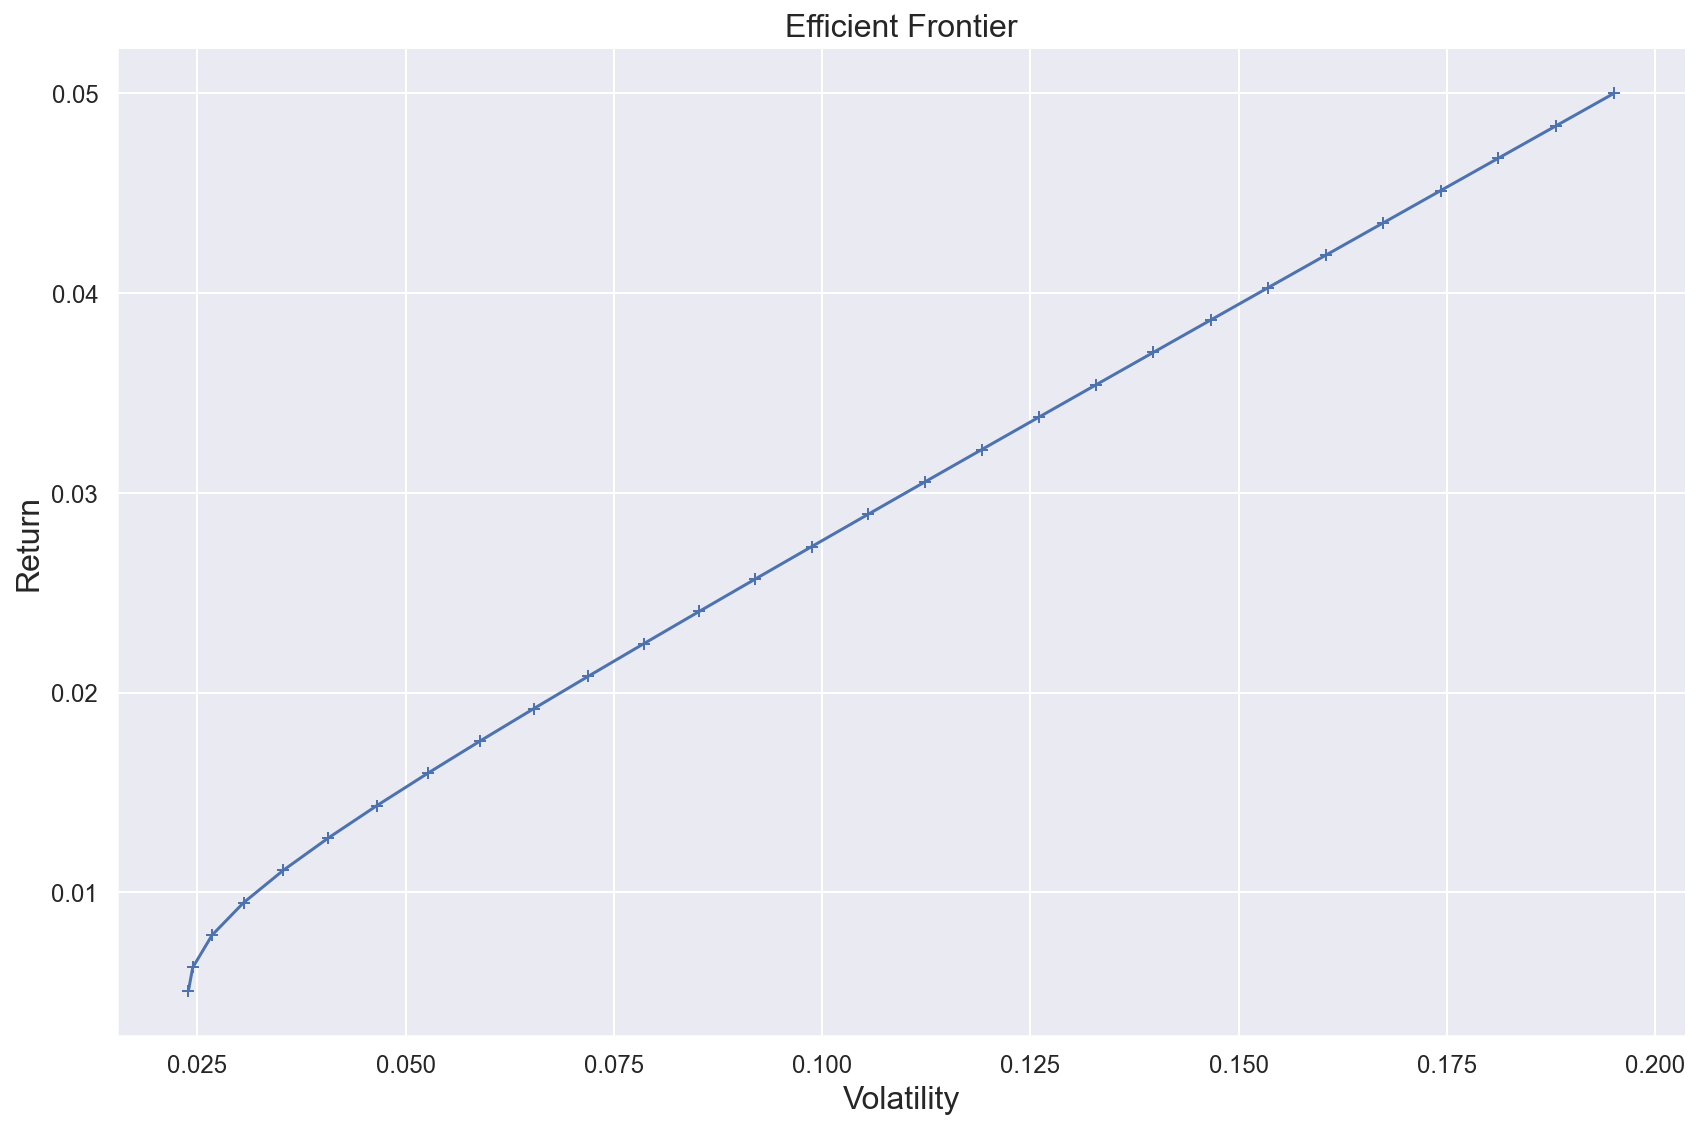

In [123]:
fig, ax = plt.subplots(figsize=(12,8))
_ = plt.plot(vols,rets,marker = '+')
_ = plt.title('Efficient Frontier')
_ = plt.xlabel('Volatility')
_ = plt.ylabel('Return')
plt.tight_layout()
sns.despine()
plt.show()

#### Part 5

In [124]:
mu_stars = np.linspace(0.003,0.05,30)
results = np.array([ run_markowits(m_mu,m_sigma,mu_star) for mu_star in mu_stars])
m_vols = results[:,2]
m_rets = results[:,1]

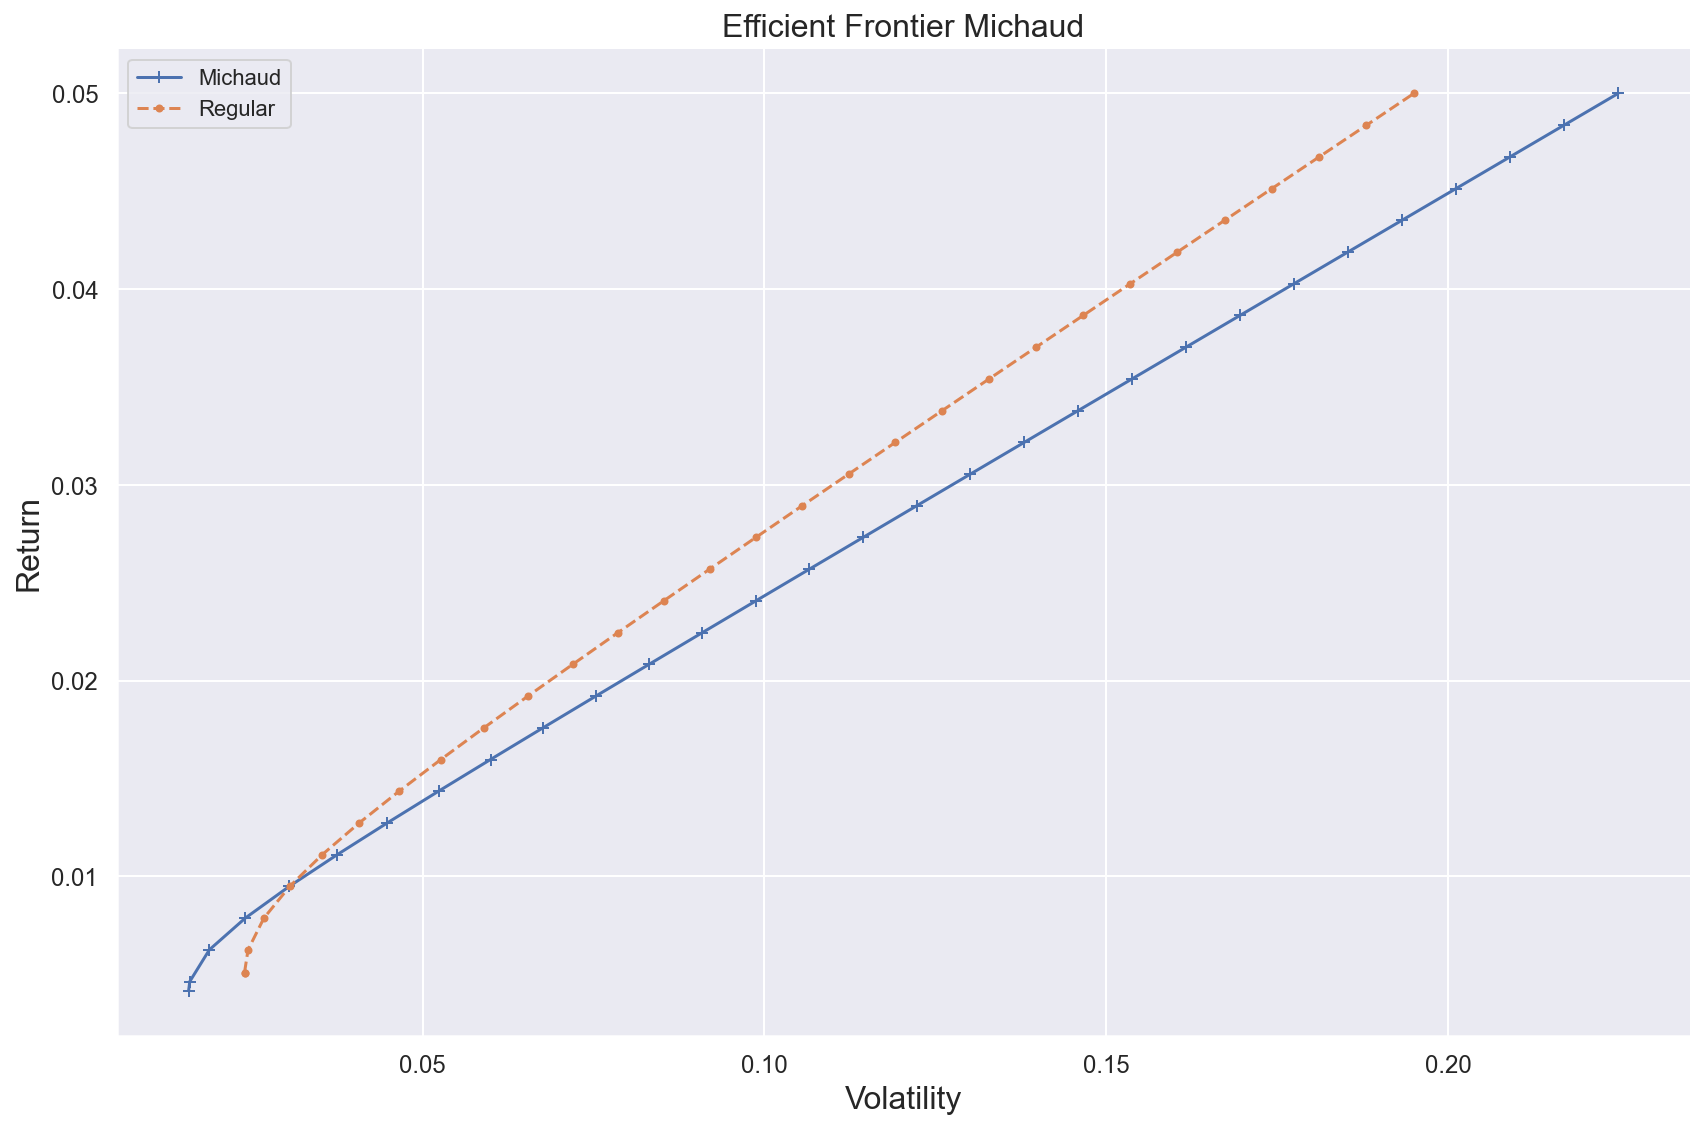

In [125]:
fig, ax = plt.subplots(figsize=(12,8))
_ = plt.plot(m_vols,m_rets,marker = '+')
_ = plt.plot(vols,rets,linestyle='--',marker='.')
_ = plt.title('Efficient Frontier Michaud')
_ = plt.xlabel('Volatility')
_ = plt.ylabel('Return')
_ = plt.legend(['Michaud','Regular'])
plt.tight_layout()
sns.despine()
plt.show()

###### TODO Add Commentary


### Exercise 4

The file portfolio_data.csv contains historical monthly returns for one set of 6 portfolios and another set of 25 portfolios, formed based on Size and Book-to-Market ratio (BM). The data is obtained from French’s data library. The portfolios are formed as the intersection of size (or market equity, ME) based portfolios and book equity to market equity ratio (BE/ME) based portfolios (2×3 forming the first set of 6 portfolios and 5 × 5 forming the second set of 25 portfolios). These portfolios are discussed in the 1993 paper by Fama and French.

In this exercise we will only work with the first set of 6 portfolios, which are contained in the columns named beginning with “PF6,” with the rest of the column names following French’s naming convention about the size and BM of the corresponding portfolios – SML contains small size + low BM, SM2 contains small size + medium BM, SMH contains small size + high BM, BIGL contains big size + low BM, etc. Finally, the last 4 columns of the data set contain the Fama-French factors themselves along with the risk-free rate: MktMinusRF contains the excess return of the market over the risk-free rate, SMB contains the small-minus-big size factor, HML
contains the high-minus-low BM factor and RF contains the risk-free rate.

1. Using the entire sample, regress the excess returns (over the risk-free rate) of each of the 6 portfolios on the excess market return, and perform tests with a size of 5% that the intercept is 0. Report the point estimates, $t$-statistics, and whether or not you reject the CAPM. Performregression diagnostics to check your specification.

2. For each of the 6 portfolios, perform the same test over each of the two equipartitioned subsamples and report the point estimates, $t$-statistics, and whether or not you reject the CAPM in each subperiod. Also include the same diagnostics as above.

3. Repeat (1) and (2) by regressing the excess portfolio returns on all three Fama-French factors (excess market return, SMB factor and HML factor).

4. Jointly test that the intercepts for all 6 portfolios are zeros using the $F$-test statistic or Hotelling’s $T^2$ for the whole sample and for each subsample when regressing on all three Fama-French factors.

5. Are the 6 portfolios excess returns (over the risk-free rate) series co-integrated? Use Johansen’s test to identify the number of co-integrating relationships.

#### Data Preparation and Exploration

In [126]:
pd.read_csv('../datasets/portfolio_data.csv').head()

,MONTH,PF6_SML,PF6_SM2,PF6_SMH,PF6_BIGL,PF6_BIG2,PF6_BIGH,PF25_SML,PF25_SM2,PF25_SM3,PF25_SM4,PF25_SMH,PF25_TWOL,PF25_TWO2,PF25_TWO3,PF25_TWO4,PF25_TWOH,PF25_THREEL,PF25_THREE2,PF25_THREE3,PF25_THREE4,PF25_THREEH,PF25_FOURL,PF25_FOUR2,PF25_FOUR3,PF25_FOUR4,PF25_FOURH,PF25_BIGL,PF25_BIG2,PF25_BIG3,PF25_BIG4,PF25_BIGH,MktMinusRF,SMB,HML,RF
0,192607,1.53,0.90,0.09,5.74,1.92,1.35,3.61,-3.69,-0.64,-1.42,-0.64,3.42,3.26,2.42,-1.27,2.46,1.56,2.86,-1.34,3.34,-2.16,3.29,1.24,1.29,0.55,2.56,3.18,6.08,2.00,2.93,0.56,2.62,-2.16,-2.92,0.22
1,192608,-0.68,2.25,5.56,2.70,2.70,6.21,-1.94,-6.78,3.81,1.21,4.82,1.59,-2.91,3.02,2.14,7.47,-1.06,1.67,2.08,4.86,8.14,0.76,4.11,1.93,2.13,4.47,1.17,4.10,1.82,5.64,7.76,2.56,-1.49,4.88,0.25
2,192609,-2.48,-0.06,-0.57,1.46,0.05,-0.46,-6.41,3.45,-5.19,3.08,0.75,-2.81,-2.32,1.15,-1.54,-2.61,-0.46,1.25,-2.37,1.01,-2.74,1.87,-0.08,-1.84,1.56,2.18,-1.37,3.66,-0.23,-0.30,-2.43,0.36,-1.38,-0.01,0.23
3,192610,-3.58,-4.60,-1.70,-3.60,-2.36,-4.05,-8.66,-10.02,-3.80,0.04,-3.06,-3.65,-3.77,-7.02,-6.29,0.08,-4.80,-2.23,-0.05,-1.73,-3.73,0.13,-1.71,-2.33,-2.93,-5.21,-3.14,-3.13,-2.21,-4.59,-5.81,-3.43,0.04,0.71,0.32
4,192611,2.72,3.74,2.16,3.30,2.81,3.24,3.77,12.42,2.31,-3.36,1.40,1.50,-2.77,4.03,3.46,1.62,1.78,4.64,3.27,3.54,3.40,3.54,2.28,3.85,5.00,1.78,4.31,2.61,1.47,3.55,2.56,2.44,-0.24,-0.31,0.31


In [127]:
#Use custom date parser. Replace MONTH with Date as index
portfolios = pd.read_csv('../datasets/portfolio_data.csv',index_col='MONTH',parse_dates=True,date_parser=lambda x: datetime.datetime.strptime(x, "%Y%m"))
portfolios.index.name = 'Date'

In [128]:
portfolios.info()
portfolios.describe()
#Data looks sensible a few portfolios have 1 N/A Value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036 entries, 1926-07-01 to 2012-10-01
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PF6_SML      1036 non-null   float64
 1   PF6_SM2      1036 non-null   float64
 2   PF6_SMH      1036 non-null   float64
 3   PF6_BIGL     1036 non-null   float64
 4   PF6_BIG2     1036 non-null   float64
 5   PF6_BIGH     1036 non-null   float64
 6   PF25_SML     1035 non-null   float64
 7   PF25_SM2     1035 non-null   float64
 8   PF25_SM3     1035 non-null   float64
 9   PF25_SM4     1035 non-null   float64
 10  PF25_SMH     1035 non-null   float64
 11  PF25_TWOL    1035 non-null   float64
 12  PF25_TWO2    1035 non-null   float64
 13  PF25_TWO3    1035 non-null   float64
 14  PF25_TWO4    1035 non-null   float64
 15  PF25_TWOH    1035 non-null   float64
 16  PF25_THREEL  1035 non-null   float64
 17  PF25_THREE2  1035 non-null   float64
 18  PF25_THREE3  1035 non-null   f

,PF6_SML,PF6_SM2,PF6_SMH,PF6_BIGL,PF6_BIG2,PF6_BIGH,PF25_SML,PF25_SM2,PF25_SM3,PF25_SM4,PF25_SMH,PF25_TWOL,PF25_TWO2,PF25_TWO3,PF25_TWO4,PF25_TWOH,PF25_THREEL,PF25_THREE2,PF25_THREE3,PF25_THREE4,PF25_THREEH,PF25_FOURL,PF25_FOUR2,PF25_FOUR3,PF25_FOUR4,PF25_FOURH,PF25_BIGL,PF25_BIG2,PF25_BIG3,PF25_BIG4,PF25_BIGH,MktMinusRF,SMB,HML,RF
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.00000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,0.983446,1.271187,1.472490,0.891911,0.960367,1.173147,0.729700,1.088947,1.300570,1.445459,1.672570,0.868406,1.227411,1.314783,1.356580,1.474667,0.963971,1.15885,1.256647,1.278222,1.416319,0.977749,1.026348,1.125014,1.224908,1.326841,0.887179,0.891527,0.941594,0.985053,0.059295,0.624431,0.233832,0.385357,0.291129
std,7.771216,7.092425,8.303498,5.365370,5.799497,7.243267,12.194947,10.538073,9.187466,8.608068,9.540571,7.956661,7.852274,7.318907,7.588162,8.716889,7.626806,6.58649,6.736675,6.805263,8.602335,6.225472,6.281672,6.395474,6.992893,8.944638,5.462320,5.221437,5.728135,6.880553,13.188036,5.441015,3.302716,3.550280,0.253396
min,-32.320000,-31.100000,-33.060000,-28.080000,-28.010000,-35.450000,-49.360000,-43.090000,-36.580000,-35.780000,-34.870000,-32.710000,-32.500000,-30.580000,-32.770000,-34.640000,-29.630000,-29.09000,-33.490000,-31.580000,-37.280000,-28.880000,-28.830000,-32.030000,-34.450000,-40.080000,-28.210000,-25.100000,-31.120000,-36.420000,-99.990000,-29.040000,-16.390000,-13.450000,-0.060000
25%,-3.175000,-1.975000,-2.040000,-1.830000,-1.675000,-1.900000,-4.810000,-3.455000,-2.615000,-2.155000,-2.140000,-3.610000,-2.490000,-1.940000,-2.050000,-2.095000,-3.140000,-2.06500,-1.920000,-1.905000,-2.090000,-2.360000,-2.105000,-1.990000,-2.015000,-2.270000,-1.930000,-1.740000,-1.690000,-1.915000,-2.710000,-2.147500,-1.515000,-1.292500,0.070000
50%,1.100000,1.530000,1.660000,1.195000,1.225000,1.395000,0.590000,0.990000,1.270000,1.460000,1.470000,1.190000,1.520000,1.520000,1.540000,1.690000,1.360000,1.38000,1.550000,1.490000,1.370000,1.250000,1.340000,1.500000,1.530000,1.540000,1.100000,1.060000,1.150000,1.080000,1.250000,0.975000,0.050000,0.220000,0.260000
75%,4.927500,4.652500,4.942500,4.000000,3.592500,4.327500,5.610000,5.500000,4.915000,4.510000,5.145000,5.095000,4.955000,4.565000,4.865000,5.280000,4.875000,4.66000,4.425000,4.490000,5.105000,4.610000,4.135000,4.315000,4.205000,4.750000,3.940000,3.915000,3.690000,3.980000,4.420000,3.682500,1.772500,1.742500,0.430000
max,65.630000,64.120000,85.240000,32.550000,51.520000,68.250000,147.500000,139.270000,81.040000,105.070000,105.310000,54.130000,84.410000,78.790000,72.570000,87.370000,60.750000,44.32000,64.270000,56.210000,82.060000,34.470000,57.560000,64.910000,70.670000,86.430000,35.520000,32.240000,48.410000,65.040000,56.820000,38.270000,39.040000,35.480000,1.350000


In [129]:
portfolios.loc[portfolios.PF25_SM2.isna()].index
#It's the last month. Let's remove the whole row as it does not change the analysis
portfolios = portfolios.dropna()

DatetimeIndex(['2012-10-01'], dtype='datetime64[ns]', name='Date', freq=None)

#### Part 1

In [130]:
#Select only the P6 Columns
p6_cols = [col for col in portfolios.columns if col.startswith('PF6')]
p6_returns = portfolios.loc[:,p6_cols]
p6_returns.head()

,PF6_SML,PF6_SM2,PF6_SMH,PF6_BIGL,PF6_BIG2,PF6_BIGH
Date,,,,,,
1926-07-01,1.53,0.90,0.09,5.74,1.92,1.35
1926-08-01,-0.68,2.25,5.56,2.70,2.70,6.21
1926-09-01,-2.48,-0.06,-0.57,1.46,0.05,-0.46
1926-10-01,-3.58,-4.60,-1.70,-3.60,-2.36,-4.05
1926-11-01,2.72,3.74,2.16,3.30,2.81,3.24


In [131]:
factor_returns = portfolios.loc[:,['MktMinusRF','SMB','HML','RF']]
factor_returns.head()

,MktMinusRF,SMB,HML,RF
Date,,,,
1926-07-01,2.62,-2.16,-2.92,0.22
1926-08-01,2.56,-1.49,4.88,0.25
1926-09-01,0.36,-1.38,-0.01,0.23
1926-10-01,-3.43,0.04,0.71,0.32
1926-11-01,2.44,-0.24,-0.31,0.31


In [132]:
excess_ret = p6_returns.sub(factor_returns.RF,axis=0)

We uses the statsmodel OLS that is very easy to use. We collect the most important stats but we also save the models to run the diagnostics later on

In [133]:
results = []
models = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']
X = factor_returns.MktMinusRF
X = sm.add_constant(X)

for port in p6_cols:
    y = excess_ret.loc[:,port]
    res = sm.OLS(y,X).fit()
    models[port] = res
    
    df = pd.DataFrame([res.params,res.bse,res.tvalues,res.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    results.append(df.set_index(['Portfolio','Ind. Variable']))
     
results = pd.concat(results)

results

Estimate  Std. Error     t value        p value
Portfolio Ind. Variable                                                 
PF6_SML   const         -0.102074    0.110741   -0.921735   3.568822e-01
          MktMinusRF     1.275001    0.020221   63.053671   0.000000e+00
PF6_SM2   const          0.239747    0.093238    2.571341   1.026951e-02
          MktMinusRF     1.185304    0.017025   69.621794   0.000000e+00
PF6_SMH   const          0.350184    0.128460    2.726019   6.518782e-03
          MktMinusRF     1.329359    0.023456   56.674039  2.766965e-319
PF6_BIGL  const          0.000219    0.036729    0.005949   9.952543e-01
          MktMinusRF     0.964069    0.006707  143.750050   0.000000e+00
PF6_BIG2  const          0.032859    0.053916    0.609446   5.423629e-01
          MktMinusRF     1.019297    0.009845  103.536709   0.000000e+00
PF6_BIGH  const          0.127014    0.097513    1.302532   1.930249e-01
          MktMinusRF     1.203549    0.017805   67.594406   0.000000e+00

Of all the portfolios examined we see that only SM2 and SMH have statistically significant p-values indicating that the excess returns is different from 0. So for these 2 portfolios we reject the CAPM model implying that these 2 portfolios have **alpha**. All other portfolios do not seem to have any alpha.

Before we confirm the results it's good practice to run some diagnostics on the residuals of the model fit. Python does not have very good plots for these while R has good ones out of the box. The below function replicates the R based plots. The code was adapted from [this excellent post](https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034).
For more information about the Regression diagnostics refer to the reference section of the [R documentation](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/plot.lm)

We'll run it as an example for on portfolio: SM2. the studend can run this for the other portfolios.

In [139]:
def create_diagnostic_plots(res,y,title=''):
    
    #fitted values
    model_fitted_y = res.fittedvalues
    # model residuals
    model_residuals = res.resid
    # normalized residuals
    model_norm_residuals = res.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = res.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = res.get_influence().cooks_distance[0]
    
    fig,ax = plt.subplots(2,2, figsize=(16,10))
    _ = fig.suptitle(title,y = 1, fontsize=16)
    
    #Residual vs. Fitted
    sns.residplot(model_fitted_y,y, lowess=True, scatter_kws={'alpha': 0.5},line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax =ax[0,0])
    _ = ax[0,0].set_title('Residuals vs Fitted')
    _ = ax[0,0].set_xlabel('Fitted values')
    _ = ax[0,0].set_ylabel('Residuals')
    #_ = ax[0,0].axes.set_xlim(-5,5)

    #Normal QQ Plot
    pplot = sm.ProbPlot(model_norm_residuals)
    _ = pplot.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1,ax=ax[0,1])
    _ =  ax[0,1].set_title('Normal Q-Q')
    _ =  ax[0,1].set_xlabel('Theoretical Quantiles')
    _ =  ax[0,1].set_ylabel('Standardized Residuals')
    #_ =  ax[0,1].axes.set_xlim(-3,3)

    #Scale Location Plot
    _ = ax[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    _ = sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax[1,0]
               );
    _ = ax[1,0].set_title('Scale-Location')
    _ = ax[1,0].set_xlabel('Fitted values')
    _ = ax[1,0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    
    #Leverage Plot
    _ = ax[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5);
    _ = sns.regplot(model_leverage, model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax[1,1]
               );
    _ = ax[1,1].set_xlim(0, max(model_leverage)+0.01)
    _ = ax[1,1].set_ylim(-3, 5)
    _ = ax[1,1].set_title('Residuals vs Leverage')
    _ = ax[1,1].set_xlabel('Leverage')
    _ = ax[1,1].set_ylabel('Standardized Residuals');   

    
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        ax[1,1].plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(res.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    ax[1,1].legend();
    
    
    sns.despine()
    plt.tight_layout()
    plt.show()

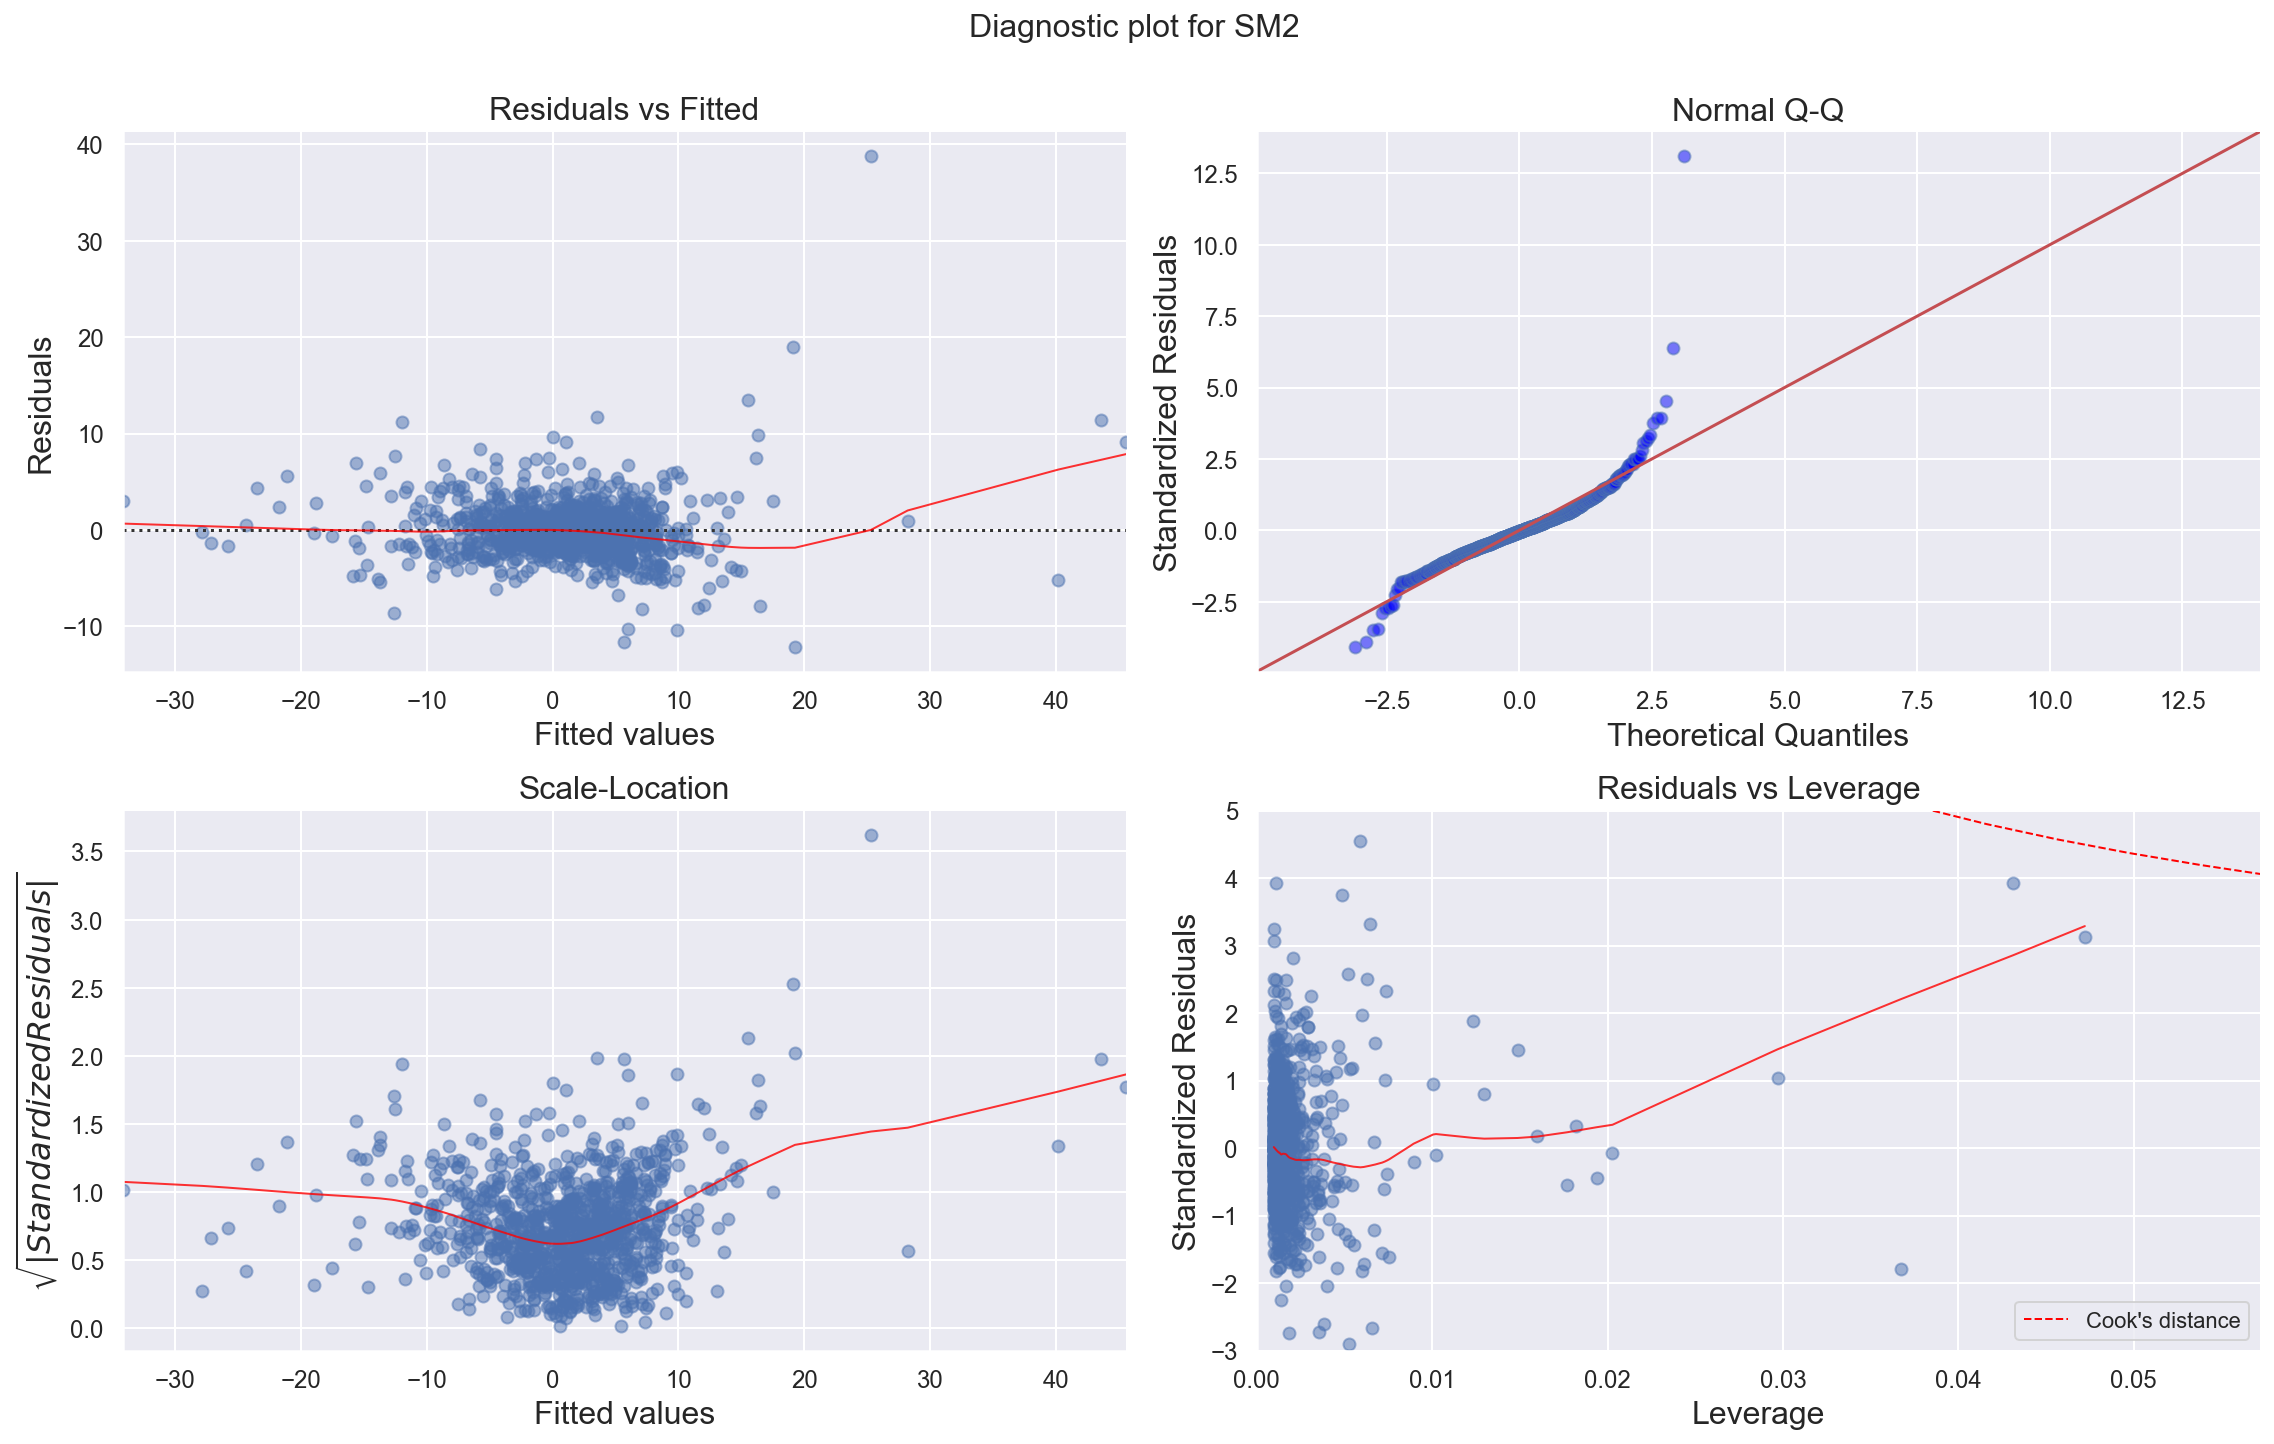

In [140]:
#Diagnostics for SM2
create_diagnostic_plots(models['PF6_SM2'],excess_ret.PF6_SM2,f'Diagnostic plot for SM2')

1. The residual vs. Fitted plot shows that the linearity assumption in the model break down due some extreme values
2. QQ Plot show that residual deviate significantly from normal and as expceted there are some heavy tails
3. Scale-Location plot shows that there is heteroscedasticity in the data i.e variance is not constant
4. Leverage plot show that none of the points are outside the Cook's distance so there is no undue influence by high leverage points

#### Part 2

We run the same analysis for 2 sub periods of the whole timeframe. Very similar analysis

In [141]:
mid_point_date = factor_returns.index[int(factor_returns.index.shape[0]/2)].date().strftime('%Y-%m-%d')
print(f'Sub-period divide date {mid_point_date}')
results_sub = []
models_sub = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']

X1 = factor_returns.loc[:mid_point_date, 'MktMinusRF']
X1 = sm.add_constant(X1)

X2 = factor_returns.loc[mid_point_date:, 'MktMinusRF']
X2 = sm.add_constant(X2)

for port in p6_cols:
    y1 = excess_ret.loc[:mid_point_date,port]
    y2 = excess_ret.loc[mid_point_date:,port]

    res1 = sm.OLS(y1,X1).fit()
    res2 = sm.OLS(y2,X2).fit()

    models_sub[f'{port}_1'] = res1
    models_sub[f'{port}_2'] = res2

    df = pd.DataFrame([res1.params,res1.bse,res1.tvalues,res1.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 1
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))

    df = pd.DataFrame([res2.params,res2.bse,res2.tvalues,res2.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 2
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))
     
results_sub = pd.concat(results_sub)

results_sub

Sub-period divide date 1969-08-01


Estimate  Std. Error     t value  \
Portfolio SubPeriod Ind. Variable                                     
PF6_SML   1         const          0.034098    0.161990    0.210498   
                    MktMinusRF     1.240220    0.026313   47.133625   
          2         const         -0.235479    0.150203   -1.567741   
                    MktMinusRF     1.333019    0.031973   41.692535   
PF6_SM2   1         const          0.162455    0.141755    1.146025   
                    MktMinusRF     1.264564    0.023026   54.918788   
          2         const          0.315046    0.116041    2.714953   
                    MktMinusRF     1.050089    0.024701   42.512233   
PF6_SMH   1         const          0.229752    0.205015    1.120655   
                    MktMinusRF     1.501426    0.033302   45.085445   
          2         const          0.463655    0.134961    3.435485   
                    MktMinusRF     1.034471    0.028728   36.008945   
PF6_BIGL  1         const          0.021325    0.047155    0.452226   
                    MktMinusRF     0.939414    0.007660  122.645712   
          2         const         -0.017708    0.055308   -0.320165   
                    MktMinusRF     1.006716    0.011773   85.510495   
PF6_BIG2  1         const         -0.051348    0.073793   -0.695841   
                    MktMinusRF     1.085707    0.011987   90.576923   
          2         const          0.114842    0.072886    1.575636   
                    MktMinusRF     0.906214    0.015515   58.409768   
PF6_BIGH  1         const          0.038761    0.144707    0.267857   
                    MktMinusRF     1.382034    0.023506   58.796120   
          2         const          0.208136    0.103971    2.001874   
                    MktMinusRF     0.897066    0.022132   40.533395   

                                         p value  
Portfolio SubPeriod Ind. Variable                 
PF6_SML   1         const           8.333623e-01  
                    MktMinusRF     4.107747e-189  
          2         const           1.175546e-01  
                    MktMinusRF     2.453691e-167  
PF6_SM2   1         const           2.523160e-01  
                    MktMinusRF     1.125935e-217  
          2         const           6.850565e-03  
                    MktMinusRF     1.020108e-170  
PF6_SMH   1         const           2.629558e-01  
                    MktMinusRF     4.244472e-181  
          2         const           6.391617e-04  
                    MktMinusRF     6.867569e-143  
PF6_BIGL  1         const           6.512960e-01  
                    MktMinusRF      0.000000e+00  
          2         const           7.489726e-01  
                    MktMinusRF     7.264830e-307  
PF6_BIG2  1         const           4.868416e-01  
                    MktMinusRF     5.843413e-319  
          2         const           1.157227e-01  
                    MktMinusRF     1.418314e-229  
PF6_BIGH  1         const           7.889166e-01  
                    MktMinusRF     7.361784e-231  
          2         const           4.582125e-02  
                    MktMinusRF     1.710690e-162

By looking at the sub periods we can now see that for all the first sub period  (prior to September 1969) to we cannot reject CAPM for any of the portfolios implying that before this time the Fama French factors were not really significant.

For the 2nd period we no reject CAPM for 3 portfolios: SM2, SMH, BIGH. We look at the diagnostics for BIGH Period 2. We leave to the student running the diagnostics on some of the other portofilos. 

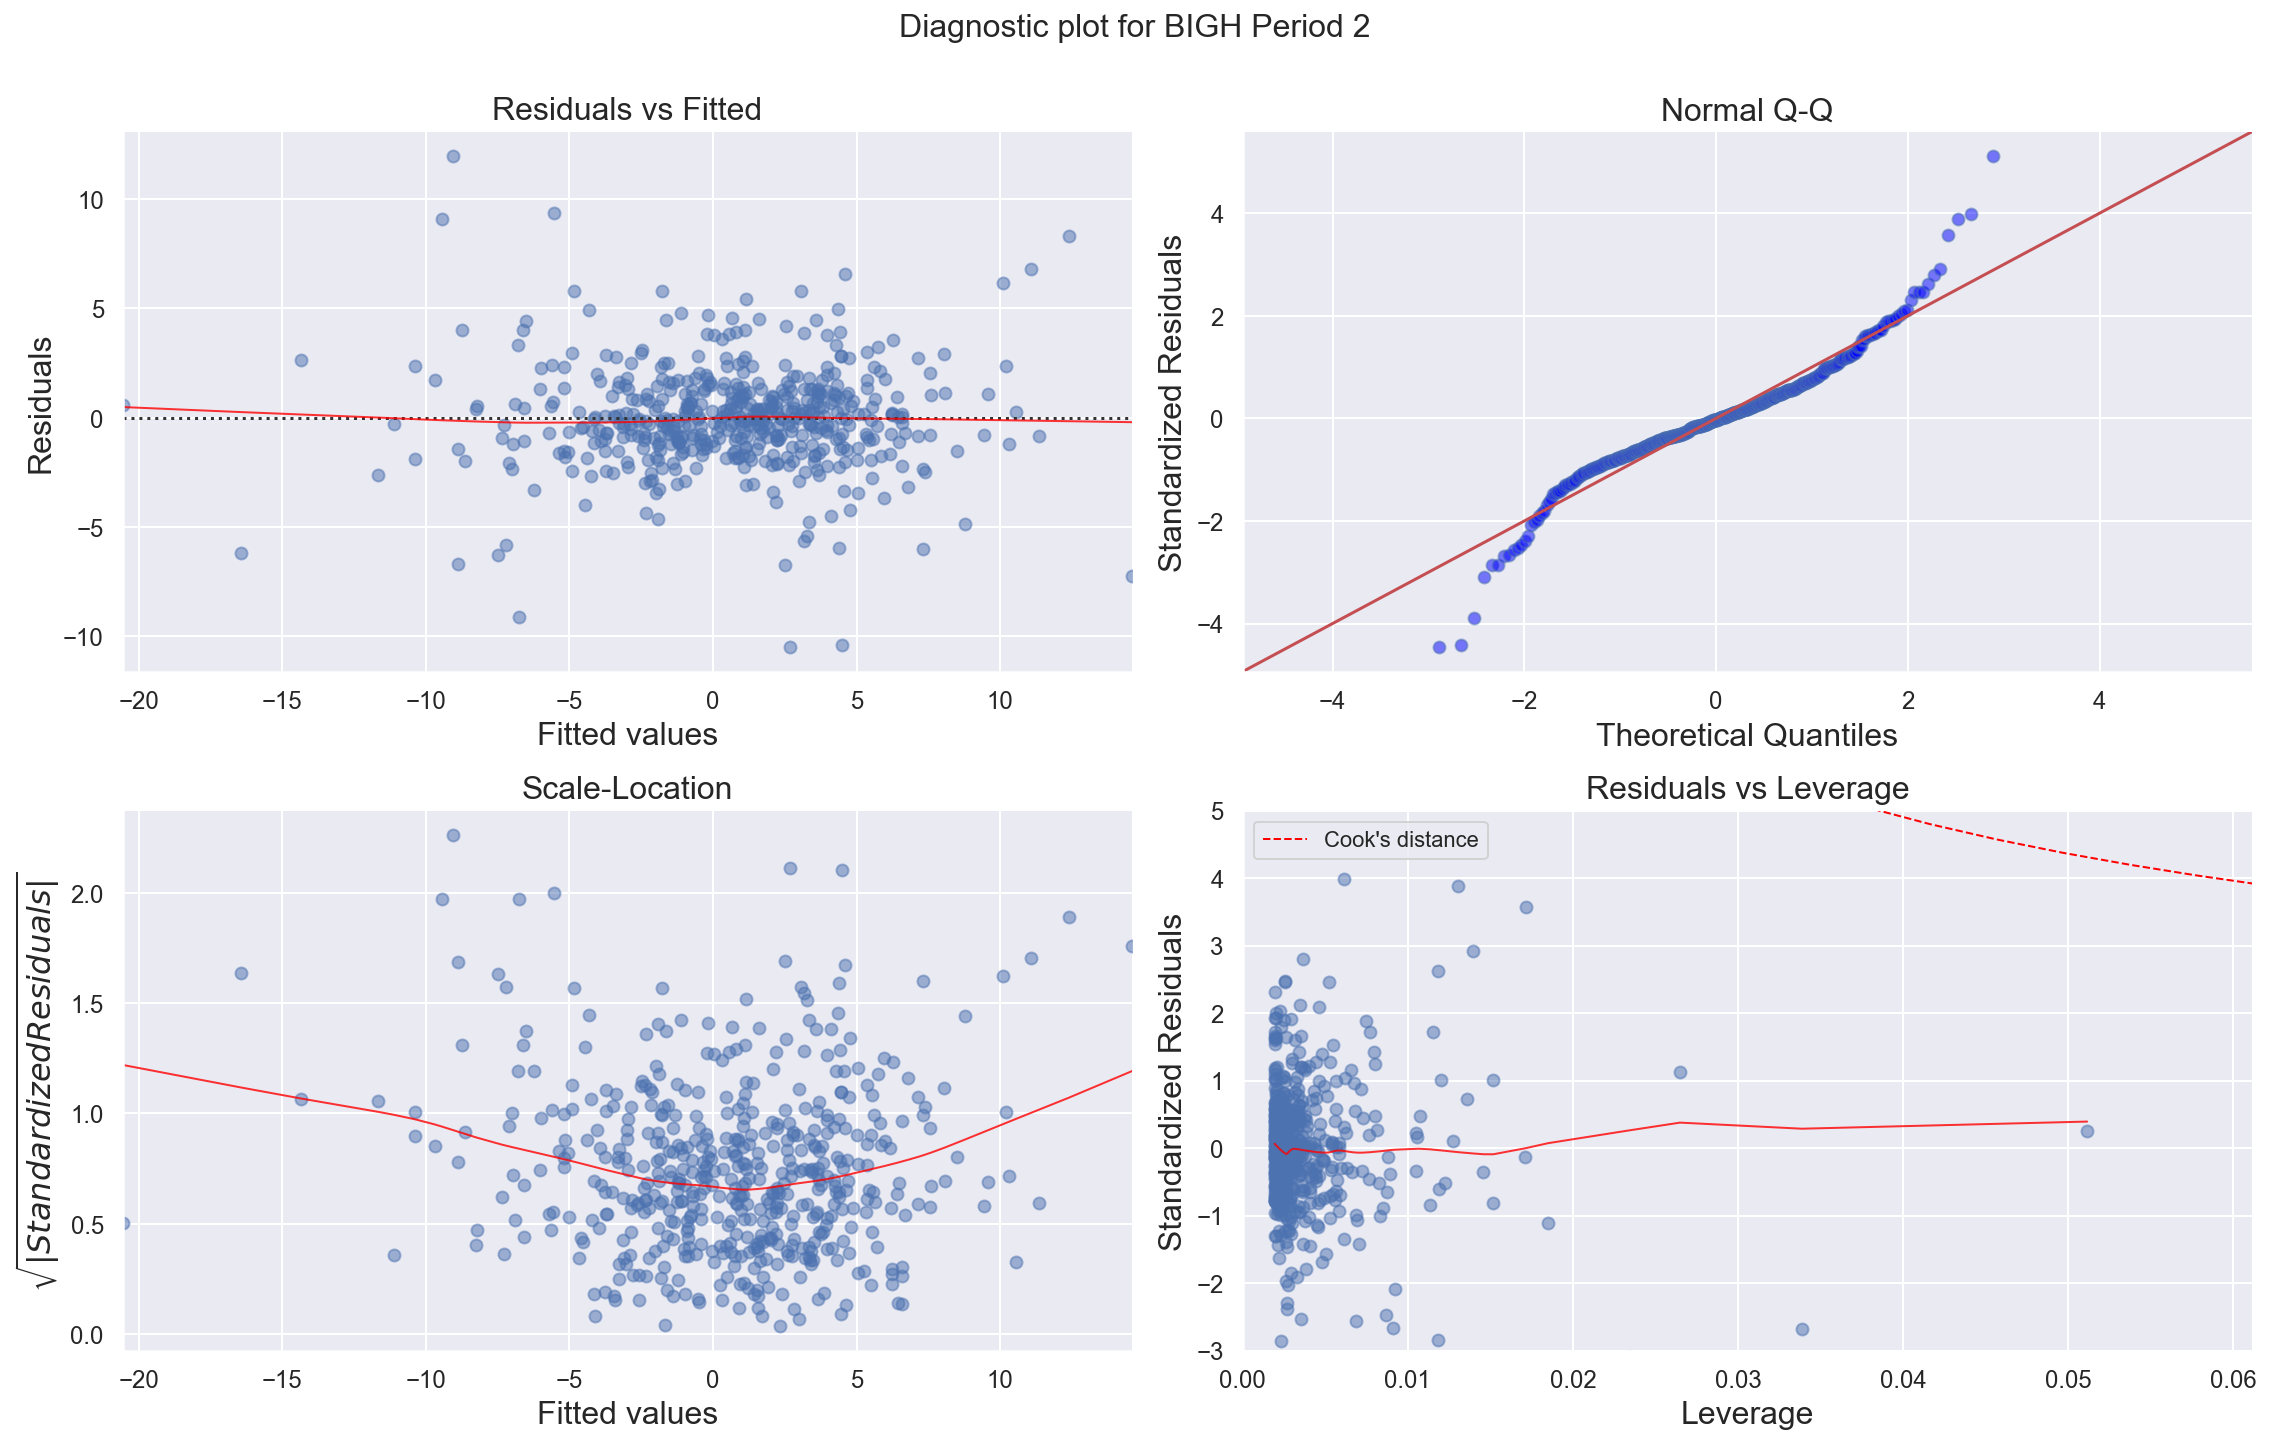

In [142]:
create_diagnostic_plots(models_sub['PF6_BIGH_2'],excess_ret.loc[mid_point_date:,'PF6_BIGH'],f'Diagnostic plot for BIGH Period 2')

1. The residual vs. Fitted plot shows that the linearity assumption holds pretty well
2. QQ Plot show that residual deviate significantly from normal and as expceted there are some heavy tails
3. Scale-Location plot shows that there is heteroscedasticity in the data i.e variance is not constant
4. Leverage plot show that none of the points are outside the Cook's distance so there is no undue influence by high leverage points

#### Part 3

This analysis expands the CAP analysis to consider the Fama-French factor model that incorporates 2 additional explanatory factors: the Size factor, SMB (Small-vs-Big) and the Momentum factor HML (High-vs-Low).


In [143]:
results = []
models = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']
X = factor_returns.loc[:,['MktMinusRF','SMB','HML']]
X = sm.add_constant(X)

for port in p6_cols:
    y = excess_ret.loc[:,port]
    res = sm.OLS(y,X).fit()
    models[port] = res
    
    df = pd.DataFrame([res.params,res.bse,res.tvalues,res.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    results.append(df.set_index(['Portfolio','Ind. Variable']))
     
results = pd.concat(results)

results

Estimate  Std. Error     t value        p value
Portfolio Ind. Variable                                                 
PF6_SML   const         -0.168258    0.039287   -4.282822   2.017709e-05
          MktMinusRF     1.088581    0.007736  140.714467   0.000000e+00
          SMB            1.050204    0.012479   84.159810   0.000000e+00
          HML           -0.167355    0.011248  -14.878328   1.675694e-45
PF6_SM2   const          0.062839    0.033400    1.881405   6.019844e-02
          MktMinusRF     0.976500    0.006577  148.472634   0.000000e+00
          SMB            0.818291    0.010609   77.132027   0.000000e+00
          HML            0.302180    0.009563   31.599316  8.370016e-154
PF6_SMH   const          0.021329    0.024664    0.864773   3.873648e-01
          MktMinusRF     1.026817    0.004857  211.422085   0.000000e+00
          SMB            0.933003    0.007834  119.094983   0.000000e+00
          HML            0.783360    0.007062  110.931802   0.000000e+00
PF6_BIGL  const          0.077556    0.025116    3.087892   2.069714e-03
          MktMinusRF     1.017340    0.004946  205.700448   0.000000e+00
          SMB           -0.096590    0.007978  -12.107533   1.206890e-31
          HML           -0.230512    0.007191  -32.055294  5.501477e-157
PF6_BIG2  const         -0.049308    0.039080   -1.261743   2.073265e-01
          MktMinusRF     0.995463    0.007695  129.359643   0.000000e+00
          SMB           -0.122474    0.012413   -9.866673   5.280964e-22
          HML            0.329735    0.011189   29.469698  5.824750e-139
PF6_BIGH  const         -0.112452    0.040654   -2.766041   5.775528e-03
          MktMinusRF     1.079149    0.008005  134.801931   0.000000e+00
          SMB            0.020504    0.012913    1.587811   1.126356e-01
          HML            0.818731    0.011640   70.338594   0.000000e+00

Once we take the othe factor into account we notices 2 importand things:
1. The previous portfolios don't seem to have any alpha anymore implying the 2 factors (very significant) now explain the outperformance of the portfolios
2. Three new portfolios: SML, BIGL, and BIGH now need to reject the assumption that the alpha is non zero. 

Let's look at the performance across the 2 periods

In [144]:
mid_point_date = factor_returns.index[int(factor_returns.index.shape[0]/2)].date().strftime('%Y-%m-%d')
print(f'Sub-period divide date {mid_point_date}')
results_sub = []
models_sub = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']

X1 = factor_returns.loc[:mid_point_date, ['MktMinusRF','SMB','HML']]
X1 = sm.add_constant(X1)

X2 = factor_returns.loc[mid_point_date:, ['MktMinusRF','SMB','HML']]
X2 = sm.add_constant(X2)

for port in p6_cols:
    y1 = excess_ret.loc[:mid_point_date,port]
    y2 = excess_ret.loc[mid_point_date:,port]

    res1 = sm.OLS(y1,X1).fit()
    res2 = sm.OLS(y2,X2).fit()

    models_sub[f'{port}_1'] = res1
    models_sub[f'{port}_2'] = res2

    df = pd.DataFrame([res1.params,res1.bse,res1.tvalues,res1.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 1
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))

    df = pd.DataFrame([res2.params,res2.bse,res2.tvalues,res2.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 2
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))
     
results_sub = pd.concat(results_sub)

results_sub

Sub-period divide date 1969-08-01


Estimate  Std. Error     t value  \
Portfolio SubPeriod Ind. Variable                                     
PF6_SML   1         const         -0.103558    0.061665   -1.679350   
                    MktMinusRF     1.063297    0.012147   87.533002   
                    SMB            1.069886    0.019426   55.075057   
                    HML           -0.104254    0.018371   -5.674844   
          2         const         -0.188575    0.045616   -4.133960   
                    MktMinusRF     1.075331    0.010397  103.423785   
                    SMB            0.997454    0.014991   66.536619   
                    HML           -0.272486    0.015830  -17.213786   
PF6_SM2   1         const          0.019686    0.052457    0.375284   
                    MktMinusRF     1.014825    0.010333   98.208425   
                    SMB            0.852490    0.016525   51.587797   
                    HML            0.226002    0.015628   14.461462   
          2         const          0.088873    0.038615    2.301541   
                    MktMinusRF     0.958689    0.008801  108.923663   
                    SMB            0.804887    0.012690   63.426282   
                    HML            0.351062    0.013400   26.198911   
PF6_SMH   1         const          0.005925    0.035388    0.167426   
                    MktMinusRF     1.019782    0.006971  146.287252   
                    SMB            0.986714    0.011148   88.509571   
                    HML            0.808844    0.010543   76.719564   
          2         const          0.077747    0.029336    2.650210   
                    MktMinusRF     1.002229    0.006687  149.884976   
                    SMB            0.852660    0.009641   88.441635   
                    HML            0.688296    0.010180   67.611502   
PF6_BIGL  1         const          0.052054    0.029600    1.758602   
                    MktMinusRF     1.030087    0.005831  176.664336   
                    SMB           -0.040179    0.009324   -4.308963   
                    HML           -0.234868    0.008818  -26.634212   
          2         const          0.138381    0.036672    3.773483   
                    MktMinusRF     0.978334    0.008359  117.044362   
                    SMB           -0.170526    0.012052  -14.149631   
                    HML           -0.308295    0.012726  -24.226135   
PF6_BIG2  1         const         -0.071854    0.057497   -1.249702   
                    MktMinusRF     0.994133    0.011326   87.773030   
                    SMB           -0.093777    0.018113   -5.177424   
                    HML            0.313427    0.017129   18.297614   
          2         const         -0.032406    0.053090   -0.610392   
                    MktMinusRF     1.006526    0.012101   83.178296   
                    SMB           -0.148645    0.017447   -8.519703   
                    HML            0.343913    0.018423   18.667563   
PF6_BIGH  1         const         -0.058391    0.065272   -0.894570   
                    MktMinusRF     1.073699    0.012858   83.505331   
                    SMB            0.042921    0.020562    2.087372   
                    HML            0.851831    0.019446   43.805360   
          2         const         -0.127897    0.046550   -2.747552   
                    MktMinusRF     1.051524    0.010610   99.105877   
                    SMB           -0.025807    0.015298   -1.686948   
                    HML            0.731094    0.016153   45.259332   

                                         p value  
Portfolio SubPeriod Ind. Variable                 
PF6_SML   1         const           9.369164e-02  
                    MktMinusRF     5.681248e-311  
                    SMB            9.441760e-218  
                    HML             2.321618e-08  
          2         const           4.163481e-05  
                    MktMinusRF      0.000000e+00  
                    SMB            9.426619e-255  
                    HML  

As Before for the first period we can accept the hyphtestis that there is no non-zero alpha in any portfolios. For the second period all portfolios but for BIG2 show evidence of non-zero alpha

We leave the diagnostic work to the student.

#### Part 4

The $Hoteling's T^2$ test is accessible via the statsmodel MANOVA class running a mv_test. The mv_test provides multiple test but we'll focus on just the one test. 

In [147]:
model = MANOVA(excess_ret,X,hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.0323803,6,1026,5.53703,1.16661e-05
MktMinusRF,Hotelling-Lawley trace,110.513,6,1026,18897.7,0
SMB,Hotelling-Lawley trace,686042,6,1026,1.17313e+08,0
HML,Hotelling-Lawley trace,752665,6,1026,1.28706e+08,0


The p-values for the intercept (const) is small thus we need to reject the the null hypothesis that all intercepts are 0 thus at least one of these portfolios has $\alpha$.

Let's re-run for the separate periods:

__Period 1__:

In [148]:
model = MANOVA(excess_ret.loc[:mid_point_date],X.loc[:mid_point_date],hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.0263719,6,509,2.23721,0.0384944
MktMinusRF,Hotelling-Lawley trace,208.502,6,509,17687.9,0
SMB,Hotelling-Lawley trace,725173,6,509,6.15189e+07,0
HML,Hotelling-Lawley trace,708766,6,509,6.0127e+07,0


__Period 2__:

In [149]:
model = MANOVA(excess_ret.loc[mid_point_date:],X.loc[mid_point_date:],hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.062622,6,509,5.31243,2.49393e-05
MktMinusRF,Hotelling-Lawley trace,77.4818,6,509,6573.04,0
SMB,Hotelling-Lawley trace,611022,6,509,5.1835e+07,0
HML,Hotelling-Lawley trace,505369,6,509,4.28721e+07,0


The result for both periods shows the p-value is small and thus we need to reject the null. That being said Period 1 the p-value is close to our confidence level indicating that the overall $\alpha$ across all portfolios is small. 

#### Part 5

To test if and how many conintegrated series there are we use the select_coint_rank method from stats model VECM package. Under the hood this uses the coint_johansen method that can also be used directly. select_coint_rank has a summary method which makes it easier to analyze the results. We look at 5% significance level and use the Max Eigenvalue method (The trace value method gives similar results)


In [153]:
res = select_coint_rank(excess_ret,det_order=-1,k_ar_diff=0,method='maxeig',signif=0.05)

In [154]:
res.summary()

r_0,r_1,test statistic,critical value
0,1,928.9,36.63
1,2,719.3,30.44
2,3,651.7,24.16
3,4,624.4,17.80
4,5,579.0,11.22
5,6,481.0,4.130


Comparing the test statistics for different ranks (r_0) we note that they are all greater than the critical value so we have to reject that a reduced set of variables are cointegrated meaning that there are a total of 6 cointegration relationships.

### Exercise 5

The file portfolio_data.csv also contains returns on 25 size sorted portfolios along with the risk free rate, excess market return along with two Fama-French factors. The monthly data spans 1926 to 2012.
1. Fit CAPM to the 25 portfolios. Give point estimates and 95% confidence intervals of $\alpha$, $\beta$, the Sharpe index, and the Treynor index. (Hint: Use the delta method for the Sharpe and Treynor indices.)

2. Test for each portfolio the null hypothesis $\alpha = 0$.
3. Use the multivariate regression model to test for the 25 portfolios the null hypothesis $\alpha = 0$.
4. Perform a factor analysis on the excess returns of the 25 portfolios. Show the factor loadings and the rotated factor loadings. Explain your choice of the number of factors.
5. Consider the model(V$
= ^1+$<$0(V
i + ^2+$#$0 + '$
in which (V$
= ($−(3 and (V
i = (i −(3 are the excess returns of the portfolio and
market index. The model suggests that the ^ in the CAPM might not be constant
(i.e., ^1 ! ^2.) Taking February 2001 as the month $0, test for each portfolio the
null hypothesis that ^1 = ^2.
(f) Estimate $0 in (e) by the least squares criterion that minimizes the residual sum
of squares over (^1, ^2, $0).
(g) Fit the Fama-French model and repeat (a)–(c).



### Exercise 8

Consider the exchange rate data in the file exchange_rates_3.csv for 24 currencies; consider the returns on these currencies along with the market return and the risk free rate. The daily data spans 3/1/2005 to 10/4/2012. We will use the data from 2005 to 2010 to construct a portfolio and the data from 2011 to 2012 to evaluate the portfolio.
1. Compute the mean $\hat{\mu}$ and sample covariance matrix, $\hat{\Sigma}$ of the log returns.
2. Compute the shrinkage estimate $\hat{\Sigma}^*$ of the covariance matrix, under a one-factor model.
3. Estimate the optimal weights, both with and without short selling under the regular estimate of - and as well as under the shrinkage estimate. Also consider an equal weighted portfolio and the portfolio weighted by the inverse of variances. Compute the optimal weights for all combinations and discuss them.
4. Estimate the optimal weights using LASSO both for short and no-short positions.
5. Evaluate the different weighting schemes in terms of their performance during the validation period, 2011–2012. Summarize your findings and offer some intuitive explanations.

#### Data Preparation and Exploration

In [5]:
pd.read_csv('../datasets/exchange_rates_3.csv')

,C1_1,DATE,ARS,AUD,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,HKD,HUF,JPY,KRW,MXN,NOK,NZD,PLN,RUB,SAR,SEK,SGD,TRY,ZAR,days
0,1306,3/1/2005,0.336700,0.77755,0.373958,0.829738,0.882418,0.120824,0.044813,0.183271,1.36330,1.92340,0.128564,0.005556,0.009695,0.000963,0.089182,0.165322,0.71705,0.334650,0.035983,0.266624,0.151210,0.610743,0.743301,0.176507,Monday
1,1307,4/1/2005,0.337268,0.76860,0.370576,0.817194,0.857265,0.120824,0.043624,0.178816,1.32930,1.88345,0.128493,0.005420,0.009581,0.000963,0.088296,0.160654,0.70555,0.324044,0.036040,0.266645,0.146884,0.610874,0.735294,0.172862,Tuesday
2,1308,5/1/2005,0.336417,0.76660,0.369563,0.816560,0.856348,0.120824,0.043664,0.178489,1.32750,1.88800,0.128394,0.005397,0.009631,0.000956,0.088222,0.160533,0.70300,0.322331,0.036040,0.266652,0.147048,0.607054,0.727273,0.169348,Wednesday
3,1309,6/1/2005,0.336134,0.76110,0.367417,0.810340,0.850232,0.120824,0.043422,0.177029,1.31720,1.87545,0.128365,0.005314,0.009517,0.000944,0.087604,0.159327,0.69705,0.320338,0.036040,0.266652,0.145446,0.605180,0.716846,0.163666,Thursday
4,1310,7/1/2005,0.337268,0.75775,0.368732,0.811392,0.842318,0.120824,0.042957,0.175365,1.30490,1.86785,0.128332,0.005250,0.009537,0.000951,0.087958,0.158474,0.69680,0.318756,0.036040,0.266652,0.144231,0.607312,0.718391,0.166528,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,3262,4/4/2012,0.227920,1.02545,0.547285,1.003110,1.089918,0.158874,0.053220,0.176308,1.31175,1.58700,0.128786,0.004434,0.012127,0.000885,0.078116,0.173147,0.81380,0.315986,0.033960,0.266656,0.148853,0.794913,0.557958,0.127736,Wednesday
1891,3263,5/4/2012,0.227920,1.03085,0.547855,1.008522,1.086484,0.158642,0.052910,0.175549,1.30635,1.58280,0.128776,0.004431,0.012140,0.000887,0.077647,0.172906,0.81675,0.314154,0.033904,0.266656,0.148217,0.794691,0.557958,0.128079,Thursday
1892,3264,6/4/2012,0.227920,1.03090,0.547855,1.003714,1.089918,0.158549,0.052946,0.175942,1.30900,1.58790,0.128776,0.004419,0.012260,0.000884,0.077647,0.172729,0.81950,0.314604,0.033798,0.266645,0.148060,0.794691,0.557165,0.126955,Friday
1893,3265,9/4/2012,0.228050,1.03125,0.549904,1.001853,1.088021,0.158677,0.052778,0.175664,1.30705,1.58595,0.128776,0.004420,0.012287,0.000879,0.077233,0.172224,0.82210,0.312876,0.033724,0.266649,0.147123,0.793179,0.555895,0.126970,Monday


In [7]:
#Drop spurious C1_1 column as well as the 'days' column that we don't need. Rename DATE to Date for consistency
fx_data = pd.read_csv('../datasets/exchange_rates_3.csv',index_col='DATE',parse_dates=True)
fx_data = fx_data.drop(columns=['C1_1','days'])
fx_data.index.name = 'Date'
fx_data.head()

,ARS,AUD,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,HKD,HUF,JPY,KRW,MXN,NOK,NZD,PLN,RUB,SAR,SEK,SGD,TRY,ZAR
Date,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-01,0.336700,0.77755,0.373958,0.829738,0.882418,0.120824,0.044813,0.183271,1.3633,1.92340,0.128564,0.005556,0.009695,0.000963,0.089182,0.165322,0.71705,0.334650,0.035983,0.266624,0.151210,0.610743,0.743301,0.176507
2005-04-01,0.337268,0.76860,0.370576,0.817194,0.857265,0.120824,0.043624,0.178816,1.3293,1.88345,0.128493,0.005420,0.009581,0.000963,0.088296,0.160654,0.70555,0.324044,0.036040,0.266645,0.146884,0.610874,0.735294,0.172862
2005-05-01,0.336417,0.76660,0.369563,0.816560,0.856348,0.120824,0.043664,0.178489,1.3275,1.88800,0.128394,0.005397,0.009631,0.000956,0.088222,0.160533,0.70300,0.322331,0.036040,0.266652,0.147048,0.607054,0.727273,0.169348
2005-06-01,0.336134,0.76110,0.367417,0.810340,0.850232,0.120824,0.043422,0.177029,1.3172,1.87545,0.128365,0.005314,0.009517,0.000944,0.087604,0.159327,0.69705,0.320338,0.036040,0.266652,0.145446,0.605180,0.716846,0.163666
2005-07-01,0.337268,0.75775,0.368732,0.811392,0.842318,0.120824,0.042957,0.175365,1.3049,1.86785,0.128332,0.005250,0.009537,0.000951,0.087958,0.158474,0.69680,0.318756,0.036040,0.266652,0.144231,0.607312,0.718391,0.166528


In [10]:
fx_data.info()
fx_data.describe()
#Note that it's only 24 currencies. Ignore the probem as it does not affect our analysis. For the rest data looks reasonable

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1895 entries, 2005-03-01 to 2012-10-04
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARS     1895 non-null   float64
 1   AUD     1895 non-null   float64
 2   BRL     1895 non-null   float64
 3   CAD     1895 non-null   float64
 4   CHF     1895 non-null   float64
 5   CNY     1895 non-null   float64
 6   CZK     1895 non-null   float64
 7   DKK     1895 non-null   float64
 8   EUR     1895 non-null   float64
 9   GBP     1895 non-null   float64
 10  HKD     1895 non-null   float64
 11  HUF     1895 non-null   float64
 12  JPY     1895 non-null   float64
 13  KRW     1895 non-null   float64
 14  MXN     1895 non-null   float64
 15  NOK     1895 non-null   float64
 16  NZD     1895 non-null   float64
 17  PLN     1895 non-null   float64
 18  RUB     1895 non-null   float64
 19  SAR     1895 non-null   float64
 20  SEK     1895 non-null   float64
 21  SGD     1895 non-nu

,ARS,AUD,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,HKD,HUF,JPY,KRW,MXN,NOK,NZD,PLN,RUB,SAR,SEK,SGD,TRY,ZAR
count,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000
mean,0.293372,0.858228,0.518796,0.924520,0.918029,0.139591,0.051008,0.181088,1.349309,1.741047,0.128590,0.005106,0.010176,0.000939,0.085364,0.166868,0.711964,0.342673,0.035664,0.266664,0.142655,0.692603,0.693636,0.137730
std,0.038494,0.115335,0.071638,0.073924,0.119810,0.012058,0.006493,0.013001,0.096898,0.184372,0.000346,0.000529,0.001528,0.000107,0.008039,0.013807,0.071891,0.044799,0.003288,0.000240,0.012294,0.065269,0.079866,0.015686
min,0.227920,0.607200,0.361742,0.769172,0.753778,0.120824,0.039512,0.156409,1.166250,1.366850,0.127725,0.003997,0.008059,0.000637,0.064589,0.137097,0.492200,0.140560,0.027507,0.265252,0.107660,0.587147,0.521648,0.089726
25%,0.254777,0.763525,0.458716,0.860678,0.819689,0.126710,0.045479,0.171637,1.279850,1.585650,0.128291,0.004697,0.008721,0.000866,0.077831,0.155931,0.677300,0.313536,0.033118,0.266635,0.133838,0.639397,0.641334,0.129492
50%,0.315706,0.845350,0.535992,0.940115,0.894614,0.146041,0.051507,0.179591,1.337850,1.737150,0.128631,0.005071,0.009745,0.000948,0.088633,0.165908,0.713100,0.335419,0.035396,0.266645,0.142696,0.690799,0.681663,0.138263
75%,0.325137,0.940225,0.576269,0.987484,0.984809,0.146709,0.055822,0.190318,1.418525,1.909750,0.128914,0.005401,0.011305,0.001042,0.092223,0.176736,0.763100,0.356068,0.037803,0.266656,0.150609,0.734686,0.748853,0.147165
max,0.349803,1.103000,0.650195,1.091643,1.374382,0.159134,0.068942,0.214153,1.598450,2.108350,0.129035,0.006932,0.013200,0.001110,0.101283,0.201727,0.874850,0.492975,0.043285,0.269869,0.171004,0.832848,0.869376,0.176507


#### Part 1

In [16]:
#Calculate log returns
fx_ret = fx_data.apply(lambda x: np.log(x)-np.log(x.shift())).dropna()

In [171]:
mu = fx_ret.mean(axis=0)
sigma = fx_ret.cov()
sigma.index.name='Covariance Matrix'
pd.DataFrame({'mu':mu})
sigma

,mu
ARS,-2.054157e-04
AUD,1.467052e-04
BRL,2.002624e-04
CAD,9.714838e-05
CHF,1.106722e-04
CNY,1.436689e-04
CZK,8.495199e-05
DKK,-2.181800e-05
EUR,-2.170180e-05
GBP,-1.025699e-04


,ARS,AUD,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,HKD,HUF,JPY,KRW,MXN,NOK,NZD,PLN,RUB,SAR,SEK,SGD,TRY,ZAR
Covariance Matrix,,,,,,,,,,,,,,,,,,,,,,,,
ARS,3.958326e-06,2.072286e-06,2.904038e-06,1.743232e-06,6.341166e-07,5.304041e-08,1.301359e-06,1.121168e-06,1.134322e-06,1.122444e-06,-1.416152e-08,2.145884e-06,-4.803978e-07,1.517420e-06,1.773090e-06,9.990951e-07,1.740221e-06,2.651911e-06,6.738096e-07,1.160110e-08,9.903930e-07,3.484686e-07,1.896001e-06,1.710535e-06
AUD,2.072286e-06,9.810267e-05,4.640100e-05,4.780760e-05,2.916612e-05,1.626409e-06,5.366621e-05,4.129860e-05,4.148531e-05,4.021644e-05,3.152048e-07,6.996270e-05,-9.871902e-06,3.619151e-05,2.797119e-05,5.878594e-05,8.411067e-05,8.371290e-05,2.914734e-05,1.744430e-09,5.631671e-05,1.639306e-05,5.345945e-05,7.129637e-05
BRL,2.904038e-06,4.640100e-05,1.053342e-04,2.913815e-05,1.112102e-05,5.161121e-07,3.394163e-05,2.214113e-05,2.218048e-05,2.105173e-05,1.842472e-07,4.735575e-05,-1.185533e-05,2.208490e-05,4.012905e-05,3.455248e-05,4.204324e-05,5.483947e-05,1.664787e-05,8.472407e-08,3.154620e-05,8.717260e-06,4.641762e-05,5.185823e-05
CAD,1.743232e-06,4.780760e-05,2.913815e-05,5.091127e-05,1.815357e-05,6.701110e-07,3.399173e-05,2.551682e-05,2.558944e-05,2.511957e-05,2.027735e-07,4.497355e-05,-6.142170e-06,1.786023e-05,2.071821e-05,3.787565e-05,4.408429e-05,5.376107e-05,1.848293e-05,3.985958e-08,3.626935e-05,7.932839e-06,3.111096e-05,4.251346e-05
CHF,6.341166e-07,2.916612e-05,1.112102e-05,1.815357e-05,5.513943e-05,6.843097e-07,4.180526e-05,3.778722e-05,3.777432e-05,2.466103e-05,1.869862e-07,4.459394e-05,2.132721e-05,9.939313e-06,5.212391e-06,4.009184e-05,2.895668e-05,4.158802e-05,1.741974e-05,-5.398907e-09,4.116454e-05,7.211475e-06,1.324609e-05,2.614794e-05
CNY,5.304041e-08,1.626409e-06,5.161121e-07,6.701110e-07,6.843097e-07,1.156091e-06,1.159375e-06,9.611590e-07,9.613341e-07,9.471672e-07,5.096577e-08,1.447921e-06,1.533797e-07,8.842981e-07,7.224509e-07,1.215242e-06,1.580868e-06,1.526896e-06,8.775181e-07,2.998506e-08,1.175805e-06,1.134475e-06,9.357770e-07,1.163816e-06
CZK,1.301359e-06,5.366621e-05,3.394163e-05,3.399173e-05,4.180526e-05,1.159375e-06,7.714508e-05,5.098120e-05,5.100096e-05,3.729182e-05,2.620130e-07,7.962996e-05,8.514606e-06,1.868476e-05,2.104737e-05,6.018697e-05,5.237785e-05,8.412242e-05,2.992758e-05,-2.730381e-08,6.251811e-05,1.171781e-05,3.956898e-05,5.586199e-05
DKK,1.121168e-06,4.129860e-05,2.214113e-05,2.551682e-05,3.778722e-05,9.611590e-07,5.098120e-05,4.438166e-05,4.436348e-05,3.067341e-05,2.316402e-07,5.902207e-05,1.054973e-05,1.553198e-05,1.278073e-05,4.884270e-05,4.025547e-05,5.768007e-05,2.309384e-05,2.854026e-10,5.071456e-05,9.450299e-06,2.613718e-05,3.877679e-05
EUR,1.134322e-06,4.148531e-05,2.218048e-05,2.558944e-05,3.777432e-05,9.613341e-07,5.100096e-05,4.436348e-05,4.445953e-05,3.072911e-05,2.283352e-07,5.917079e-05,1.052072e-05,1.580382e-05,1.292238e-05,4.901902e-05,4.034839e-05,5.773207e-05,2.315833e-05,4.533947e-09,5.083504e-05,9.484975e-06,2.620469e-05,3.901821e-05


#### Part2

This exercise calls for building  single factor model using the daily market and risk free rate. This data is not in the given dataset but easily downloadable from the well known French data site [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/index.html). We'll simply add the link to the csv file directly to the pandas function. There are 3 rows of header we need to remove as well as the last row.

In [63]:
market_data = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip',skiprows=3,skipfooter=1)
market_data.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


In [64]:
#Some cleanup and manipulation and we also make the date consistent
market_data = market_data.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
market_data.index = pd.to_datetime(market_data.index,format='%Y%m%d')
#market_data = market_data['2005-04':'2012-10-04']
market_data.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.24,-0.28,0.009
1926-07-02,0.45,-0.32,-0.08,0.009
1926-07-06,0.17,0.27,-0.35,0.009
1926-07-07,0.09,-0.59,0.03,0.009
1926-07-08,0.21,-0.36,0.15,0.009


In [223]:
#let's align the 2 series to ensure they are consistent and let's run an OLS on each currency to estimate the factor model
md,fx = market_data.align(fx_ret,'inner',axis=0)
X = md.loc[:,'Mkt-RF']
X = sm.add_constant(X)
currencies = fr.columns
output = {}
for cur in currencies:
    res = sm.OLS(fr.loc[:,cur],mkt_ret).fit()
    beta = res.params[1]
    res_var = np.var(res.resid)
    output[cur] = dict(beta=beta,rvar=res_var)
f_model = pd.DataFrame(output).T
f_model

,beta,rvar
ARS,-0.000014,4.193607e-06
AUD,0.001667,9.517748e-05
BRL,0.002388,9.872679e-05
CAD,0.001097,5.112897e-05
CHF,-0.000023,5.790312e-05
CNY,-0.000014,1.216816e-06
CZK,0.000996,7.793154e-05
DKK,0.000642,4.555469e-05
EUR,0.000639,4.556048e-05
GBP,0.000682,4.526792e-05


In [224]:
#Calculate the single factor 
betas = f_model.beta.values.reshape((-1,1))
D = np.diag(f_model.rvar)
mkt_var = np.var(md.loc[:,'Mkt-RF'])
F = mkt_var*betas * betas.T + D

In [235]:
# Calculating the shrinkage coeefficient is somwhat involved. Please refer to the paper/book
def calc_shrinkage_factor(p_ret, F, S):
    N,p = p_ret.shape
    gamma_hat =np.sum((F-S)**2)
    
    #normalized rets
    pret_n = p_ret - p_ret.mean()
    
    #calculate pi_hat
    Pi = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            Pi[i,j] = np.sum((pret_n[:,i]*pret_n[:,j] - S[i,j])**2)/N
    pi_hat = np.sum(Pi)
    
    #calculate rho
    sigma_hat = 0
    for i in range(p):
        for j in range(i,p):
            sigma_hat += S[i,j]/np.sqrt(S[i,i]*S[j,j])
    sigma_hat = 2*sigma_hat/(p*p-1)
    
    Theta = np.zeros((p,p,p))
    for i in range(p):
        for j in range(p):
            for k in range(p):
                Theta[k,i,j] = np.sum((pret_n[:,k]**2 - S[k,k])*(pret_n[:,i]*pret_n[:,j] - S[i,j]))/N
                
    rho_hat = np.sum(np.diag(Pi))
    for i in range(p):
        for j in range(p):
            if i != j:
                rho_hat += (np.sqrt(S[j,j]/S[i,i])*Theta[i,i,j] + np.sqrt(S[j,j]/S[i,i])*Theta[j,i,j])*sigma_hat/2
    
    #calculate delta
    kappa = (pi_hat-rho_hat)/gamma
    delta = min(1,max(0,kappa/N))
    return delta

In [232]:
delta = calc_shrinkage_factor(fr.values,D,sigma.values)
print(f'Shrinkage Factor: {np.round(delta,3)}')

Shrinkage Factor: 0.249


In [233]:
sigma_star = delta*F + (1-delta)*sigma

In [234]:
sigma_star

,ARS,AUD,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,HKD,HUF,JPY,KRW,MXN,NOK,NZD,PLN,RUB,SAR,SEK,SGD,TRY,ZAR
Covariance Matrix,,,,,,,,,,,,,,,,,,,,,,,,
ARS,4.017096e-06,1.543615e-06,2.162804e-06,1.300691e-06,4.761523e-07,3.991415e-08,9.697227e-07,8.370013e-07,8.468953e-07,8.376702e-07,-1.066039e-08,1.599498e-06,-3.550830e-07,1.134283e-06,1.317989e-06,7.417929e-07,1.294539e-06,1.978549e-06,5.007951e-07,8.653663e-09,7.354813e-07,2.599927e-07,1.411595e-06,1.272559e-06
AUD,1.543615e-06,9.880572e-05,3.688223e-05,3.682848e-05,2.187348e-05,1.208786e-06,4.114002e-05,3.155151e-05,3.168923e-05,3.077395e-05,2.402443e-07,5.387217e-05,-8.073925e-06,2.773694e-05,2.255359e-05,4.510813e-05,6.454682e-05,6.428850e-05,2.247891e-05,7.865140e-09,4.322813e-05,1.249513e-05,4.152428e-05,5.489150e-05
BRL,2.162804e-06,3.688223e-05,1.066262e-04,2.322221e-05,8.319741e-06,3.701467e-07,2.670447e-05,1.740975e-05,1.743581e-05,1.664178e-05,1.435178e-07,3.748904e-05,-9.849839e-06,1.739474e-05,3.235332e-05,2.734215e-05,3.357966e-05,4.324261e-05,1.335587e-05,7.298796e-08,2.504757e-05,6.815572e-06,3.684217e-05,4.089487e-05
CAD,1.300691e-06,3.682848e-05,2.322221e-05,5.158565e-05,1.361379e-05,4.950787e-07,2.607876e-05,1.951656e-05,1.956948e-05,1.924123e-05,1.546041e-07,3.465069e-05,-5.047218e-06,1.378176e-05,1.657650e-05,2.907645e-05,3.401918e-05,4.130938e-05,1.426863e-05,3.423317e-08,2.785326e-05,6.079630e-06,2.427129e-05,3.281606e-05
CHF,4.761523e-07,2.187348e-05,8.319741e-06,1.361379e-05,5.582887e-05,5.138309e-07,3.136873e-05,2.835682e-05,2.834717e-05,1.850339e-05,1.403084e-07,3.345517e-05,1.601800e-05,7.452981e-06,3.891290e-06,3.008086e-05,2.171657e-05,3.119753e-05,1.306764e-05,-4.142290e-09,3.088643e-05,5.410578e-06,9.923864e-06,1.960873e-05
CNY,3.991415e-08,1.208786e-06,3.701467e-07,4.950787e-07,5.138309e-07,1.171335e-06,8.630614e-07,7.168396e-07,7.169914e-07,7.060445e-07,3.822600e-08,1.075452e-06,1.207162e-07,6.589854e-07,5.291928e-07,9.039449e-07,1.174786e-06,1.133934e-06,6.536474e-07,2.245264e-08,8.745652e-07,8.499772e-07,6.906825e-07,8.620393e-07
CZK,9.697227e-07,4.114002e-05,2.670447e-05,2.607876e-05,3.136873e-05,8.630614e-07,7.785312e-05,3.859783e-05,3.861121e-05,2.834289e-05,1.988523e-07,6.058344e-05,5.994565e-06,1.436638e-05,1.672992e-05,4.576507e-05,4.015979e-05,6.401241e-05,2.282330e-05,-1.657614e-08,4.749905e-05,8.909337e-06,3.053624e-05,4.275330e-05
DKK,8.370013e-07,3.155151e-05,1.740975e-05,1.951656e-05,2.835682e-05,7.168396e-07,3.859783e-05,4.488641e-05,3.351203e-05,2.325011e-05,1.752784e-07,4.482583e-05,7.663498e-06,1.187838e-05,1.019313e-05,3.704074e-05,3.076004e-05,4.385503e-05,1.756594e-05,2.737615e-09,3.843562e-05,7.166827e-06,2.015672e-05,2.963605e-05
EUR,8.468953e-07,3.168923e-05,1.743581e-05,1.956948e-05,2.834717e-05,7.169914e-07,3.861121e-05,3.351203e-05,4.494444e-05,2.329093e-05,1.727914e-07,4.493517e-05,7.642849e-06,1.208146e-05,1.029682e-05,3.717143e-05,3.082740e-05,4.389161e-05,1.761333e-05,5.915603e-09,3.852444e-05,7.192534e-06,2.020503e-05,2.981494e-05


#### Part 3

Git Token: e7a9fd0979391c4766008c3e0ebb2b82699a9fba

In [251]:
w_short_sample,_,_ = run_markowits(mu,sigma,0.0001)
print(f'\nWeights Short Sample:{w[:,0].round(2)}')
w_noshort_sample,_,_ = run_markowits(mu,sigma,0.0001,short_restricted=True)
print(f'\nWeights No-Short Sample:{w[:,0].round(2)}')
w_short_shrink,_,_ = run_markowits(mu,sigma_star,0.0001)
print(f'\Weights Short Shrink:{w[:,0].round(2)}')
w_noshort_shrink,_,_ = run_markowits(mu,sigma_star,0.0001,short_restricted=True)
print(f'\Weights No-Short Shrink:{w[:,0].round(2)}')


Weights Short Sample:[-0.16  0.01  0.02  0.02  0.01  0.44  0.01 -0.01 -0.01 -0.01  0.33 -0.01
  0.01 -0.   -0.01 -0.   -0.   -0.   -0.01  0.38 -0.    0.02 -0.01 -0.01]

Weights No-Short Sample:[-0.16  0.01  0.02  0.02  0.01  0.44  0.01 -0.01 -0.01 -0.01  0.33 -0.01
  0.01 -0.   -0.01 -0.   -0.   -0.   -0.01  0.38 -0.    0.02 -0.01 -0.01]
\Weights Short Shrink:[-0.16  0.01  0.02  0.02  0.01  0.44  0.01 -0.01 -0.01 -0.01  0.33 -0.01
  0.01 -0.   -0.01 -0.   -0.   -0.   -0.01  0.38 -0.    0.02 -0.01 -0.01]
\Weights No-Short Shrink:[-0.16  0.01  0.02  0.02  0.01  0.44  0.01 -0.01 -0.01 -0.01  0.33 -0.01
  0.01 -0.   -0.01 -0.   -0.   -0.   -0.01  0.38 -0.    0.02 -0.01 -0.01]


In [253]:
w_eq = np.ones(24)/N

In [257]:
w_ivar = 1/np.var(fx_ret)
w_ivar /= w_ivar.sum()

In [268]:
#pd.DataFrame([{'WShortSample':]w_short_sample,'WEq':w_eq},index=w_ivar.index.values)

In [267]:
pd.concat((w_ivar,pd.Series(w_eq,index=w_ivar.index)),axis=1)

,0,1
ARS,0.011371,0.000615
AUD,0.000459,0.000615
BRL,0.000427,0.000615
CAD,0.000884,0.000615
CHF,0.000816,0.000615
CNY,0.038932,0.000615
CZK,0.000583,0.000615
DKK,0.001014,0.000615
EUR,0.001012,0.000615
GBP,0.000994,0.000615
